In [1]:
import napari
from napari.utils import nbscreenshot

# Create an empty viewer
viewer = napari.Viewer()

Validation errors in config file(s).
The following fields have been reset to the default value:

plugins -> call_order
  none is not an allowed value (type=type_error.none.not_allowed)



In [2]:
from tifffile import imread

# load the image data and inspect its shape
nuclei_mip = imread('data/nuclei.tif').max(axis=0)
print(nuclei_mip.shape)

(256, 256)


In [3]:
viewer.add_image(nuclei_mip)

<Image layer 'nuclei_mip' at 0x7fb7396b53a0>

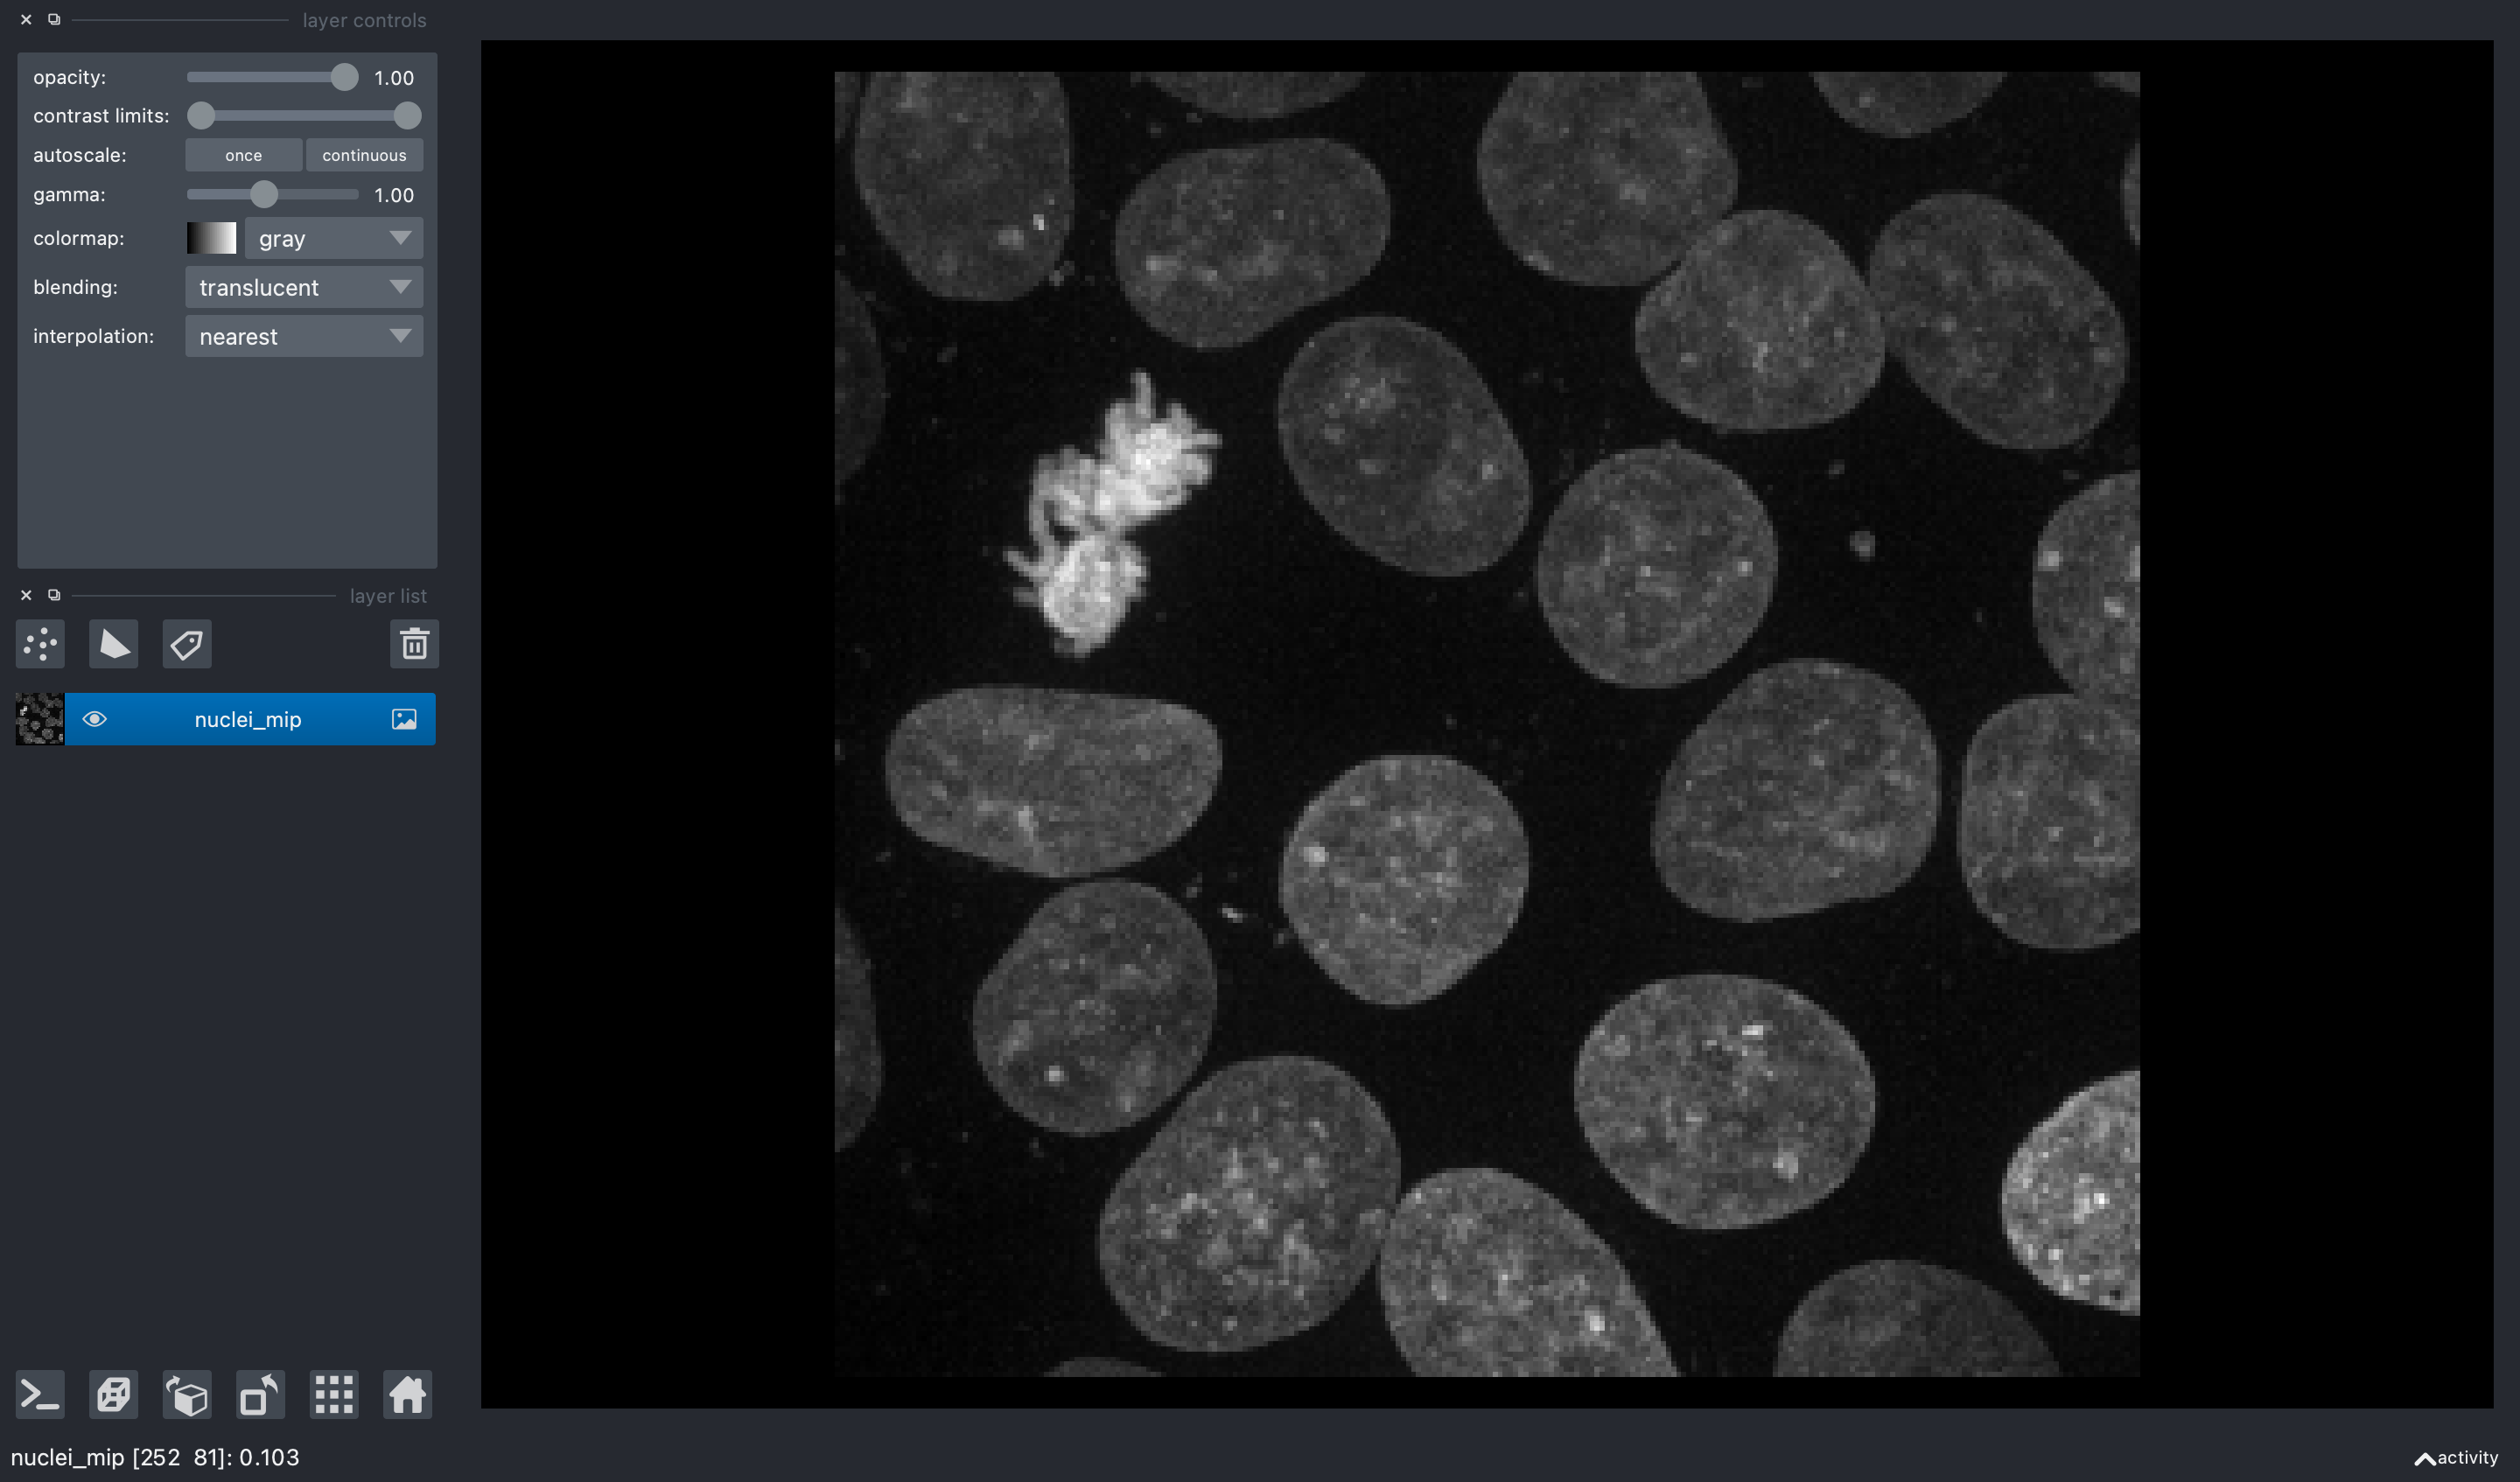

In [4]:
nbscreenshot(viewer)

In [5]:
# Import scikit-image's filtering module
from skimage import filters

In [6]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel')
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel')
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts')
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt')
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr')

<Image layer 'Scharr' at 0x7fb73cb4e700>

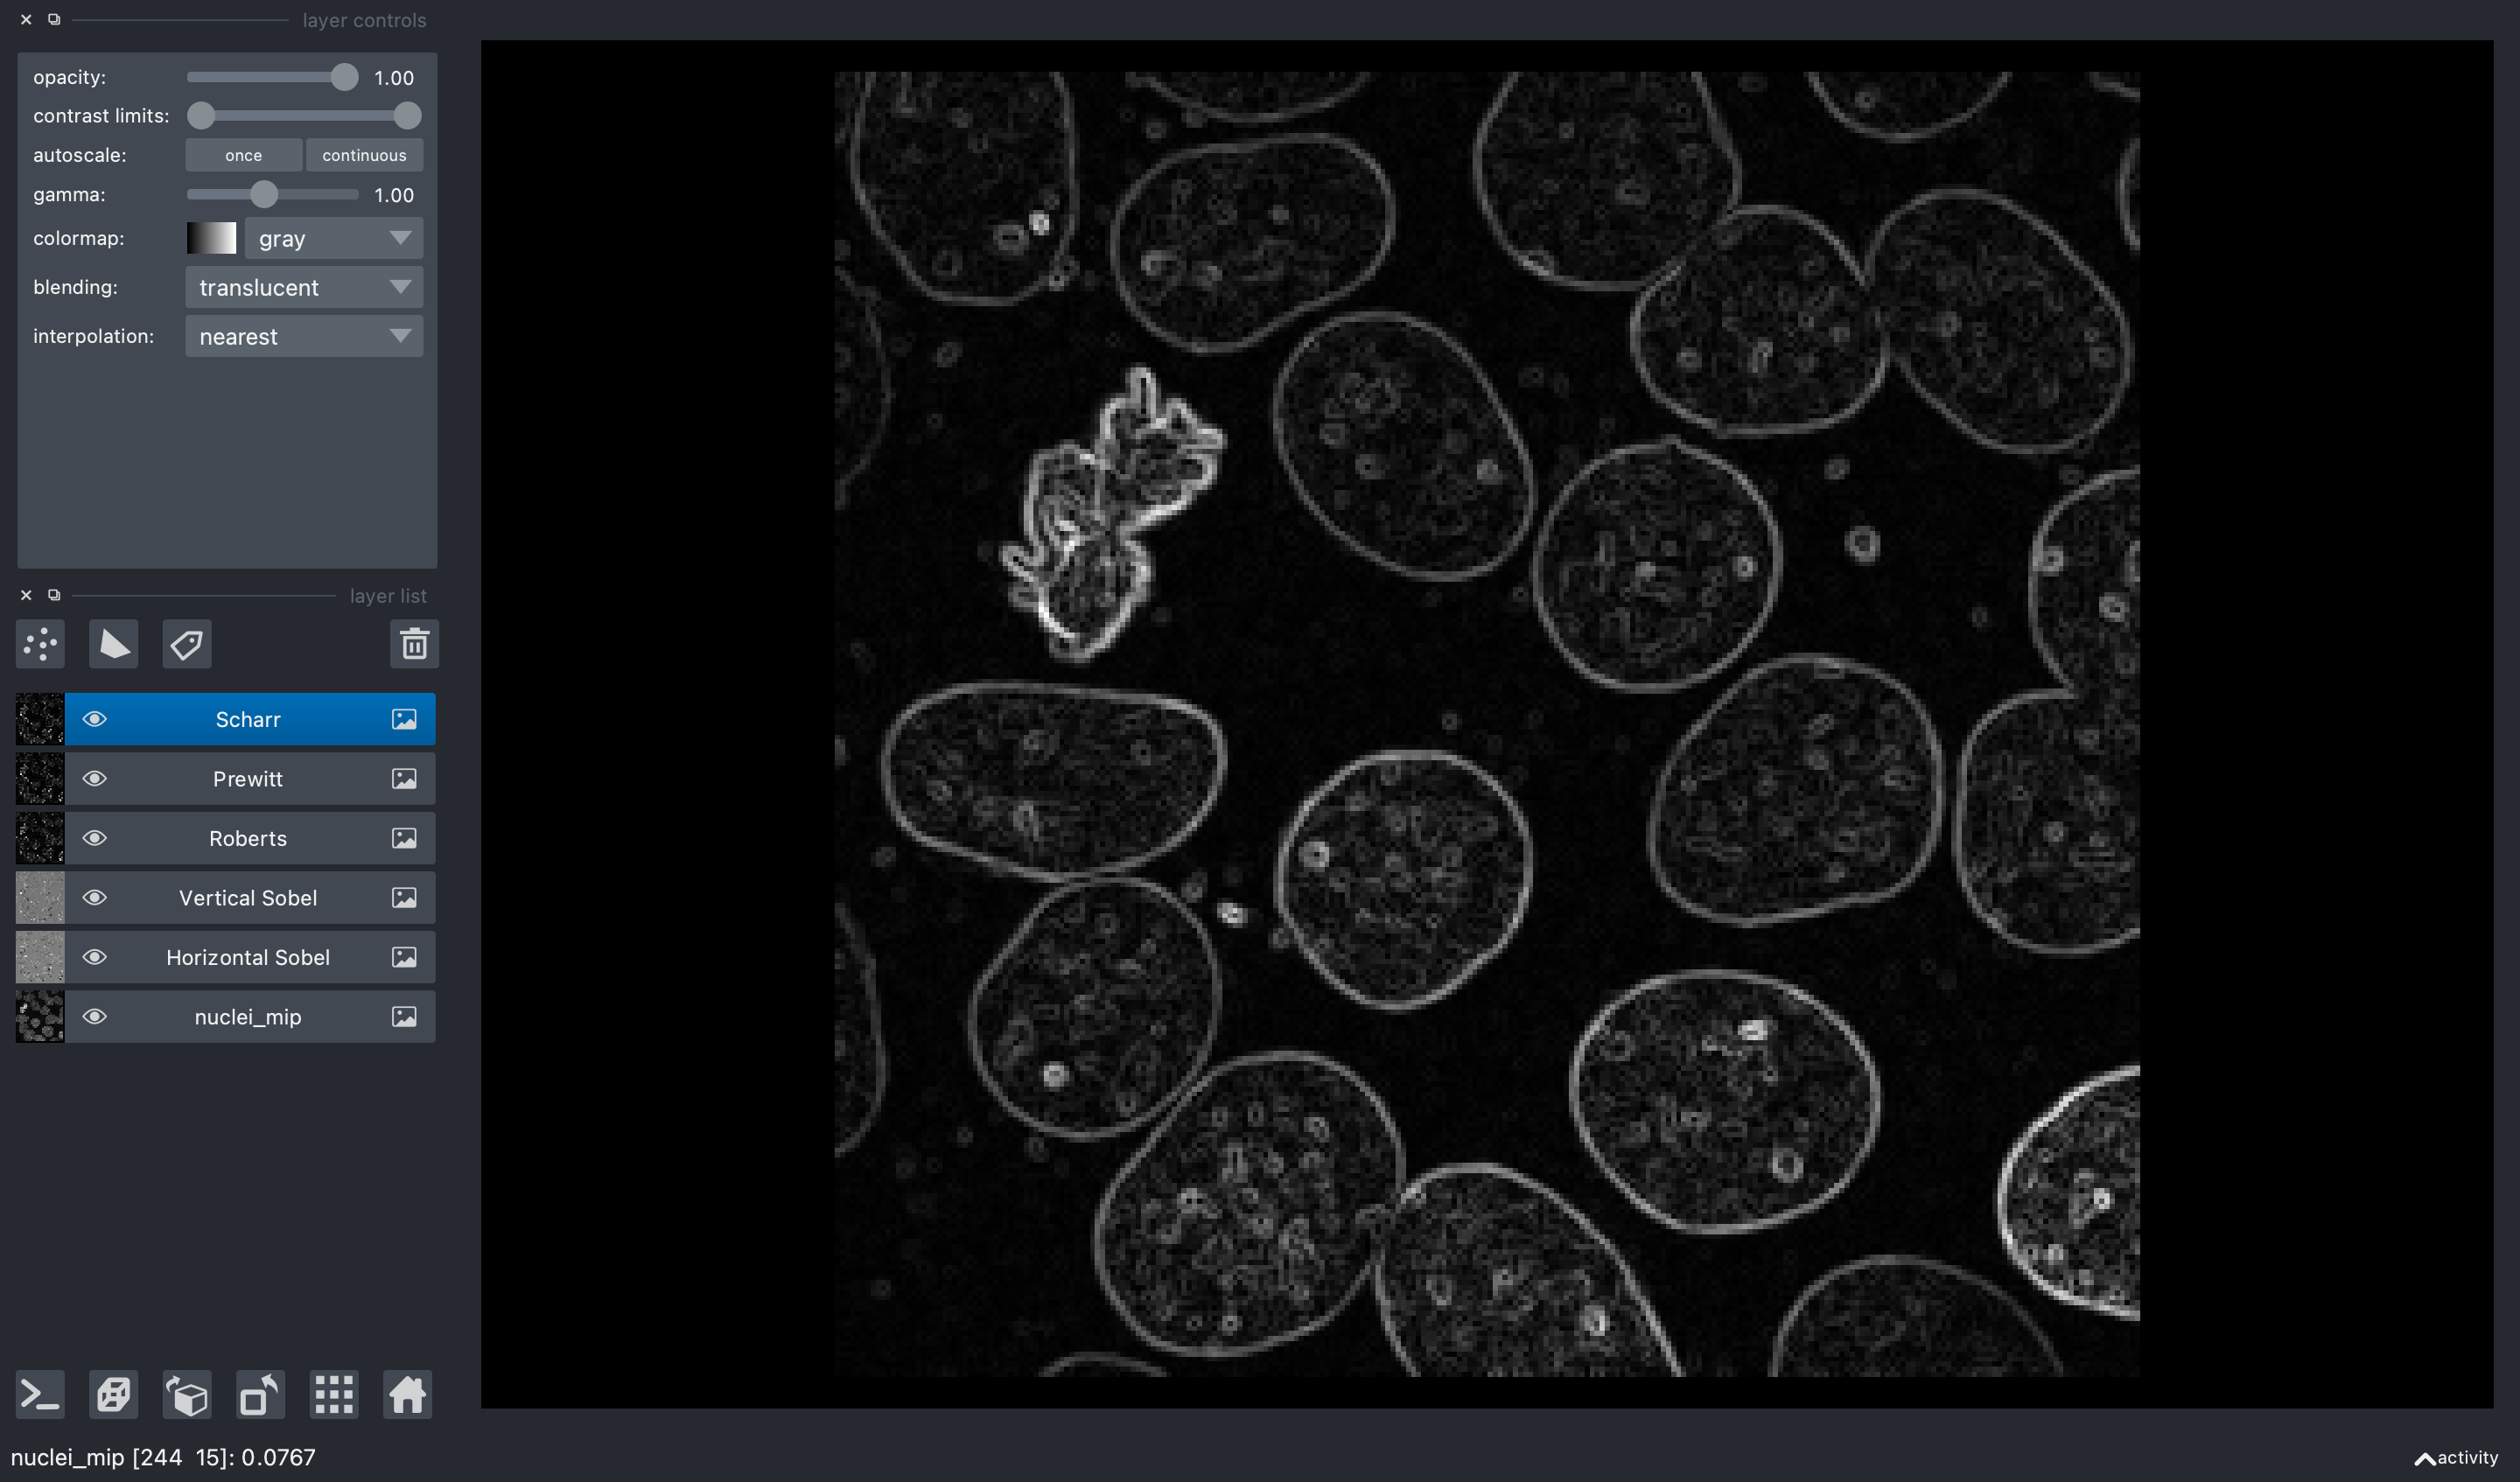

In [7]:
nbscreenshot(viewer)

In [8]:
# Remove all filter layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [9]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import numpy as np

In [10]:
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground, name='foreground')

<Labels layer 'foreground' at 0x7fb719c7fe50>

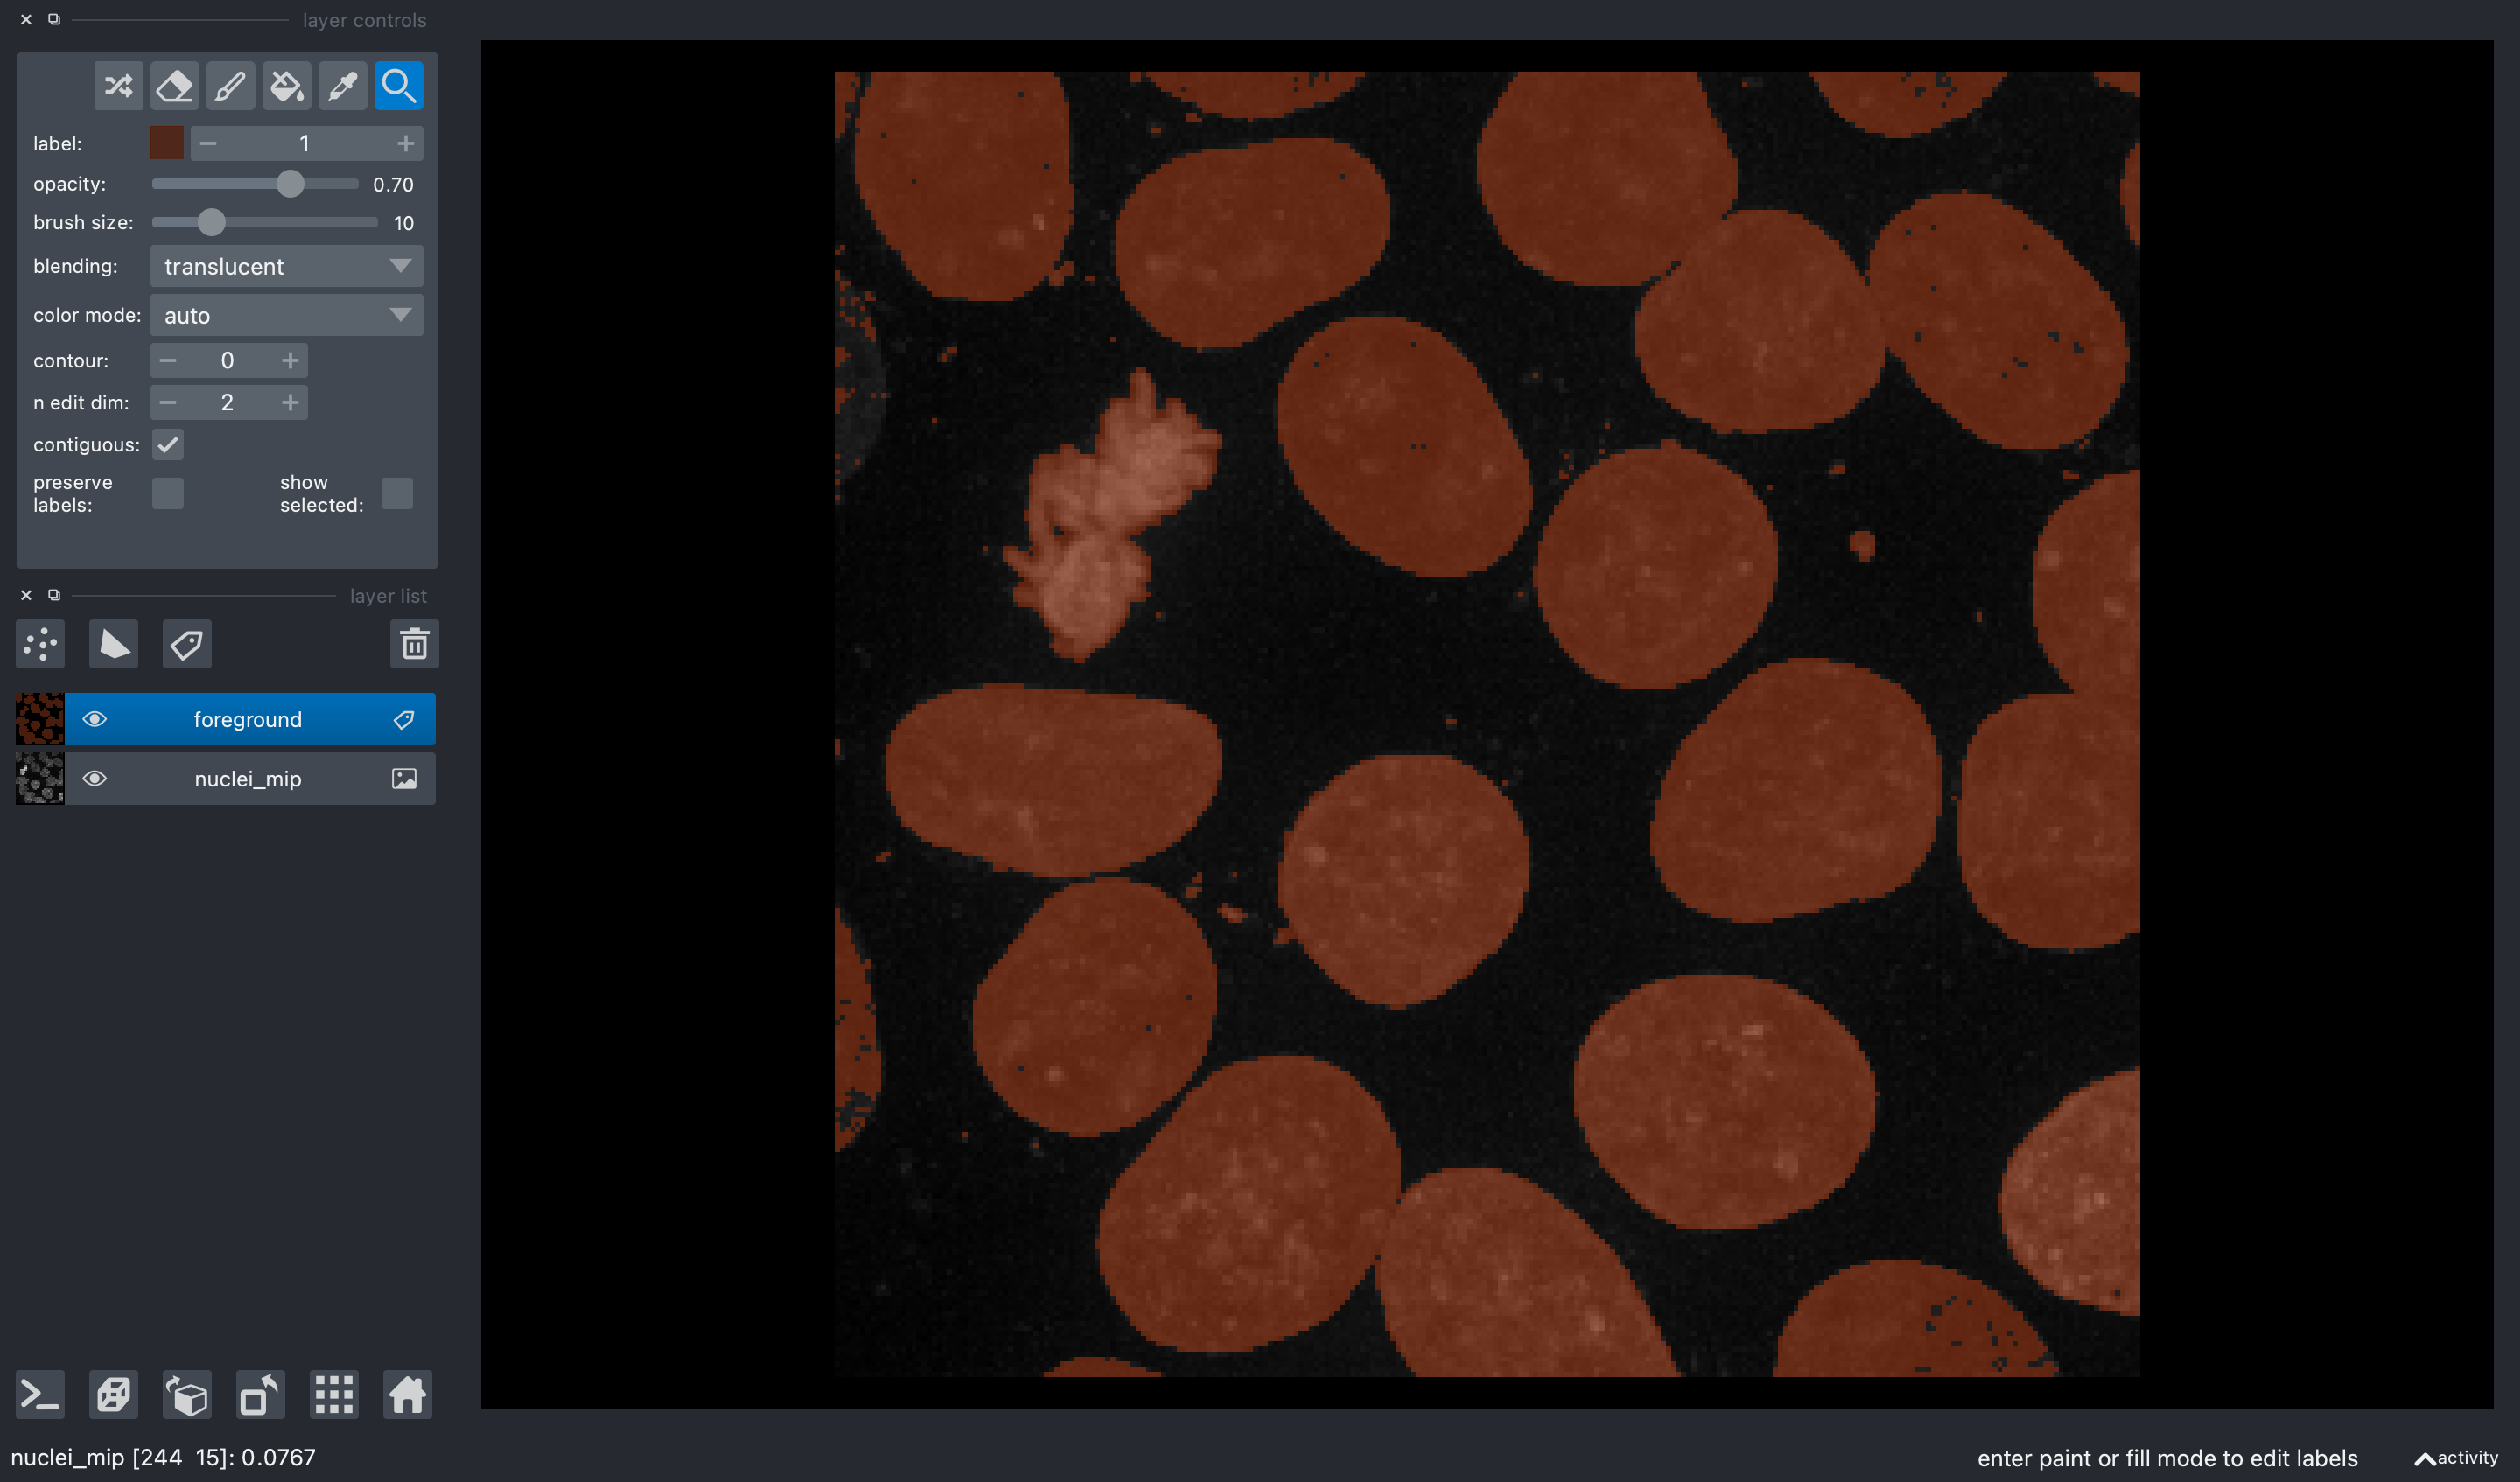

In [11]:
nbscreenshot(viewer)

In [12]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

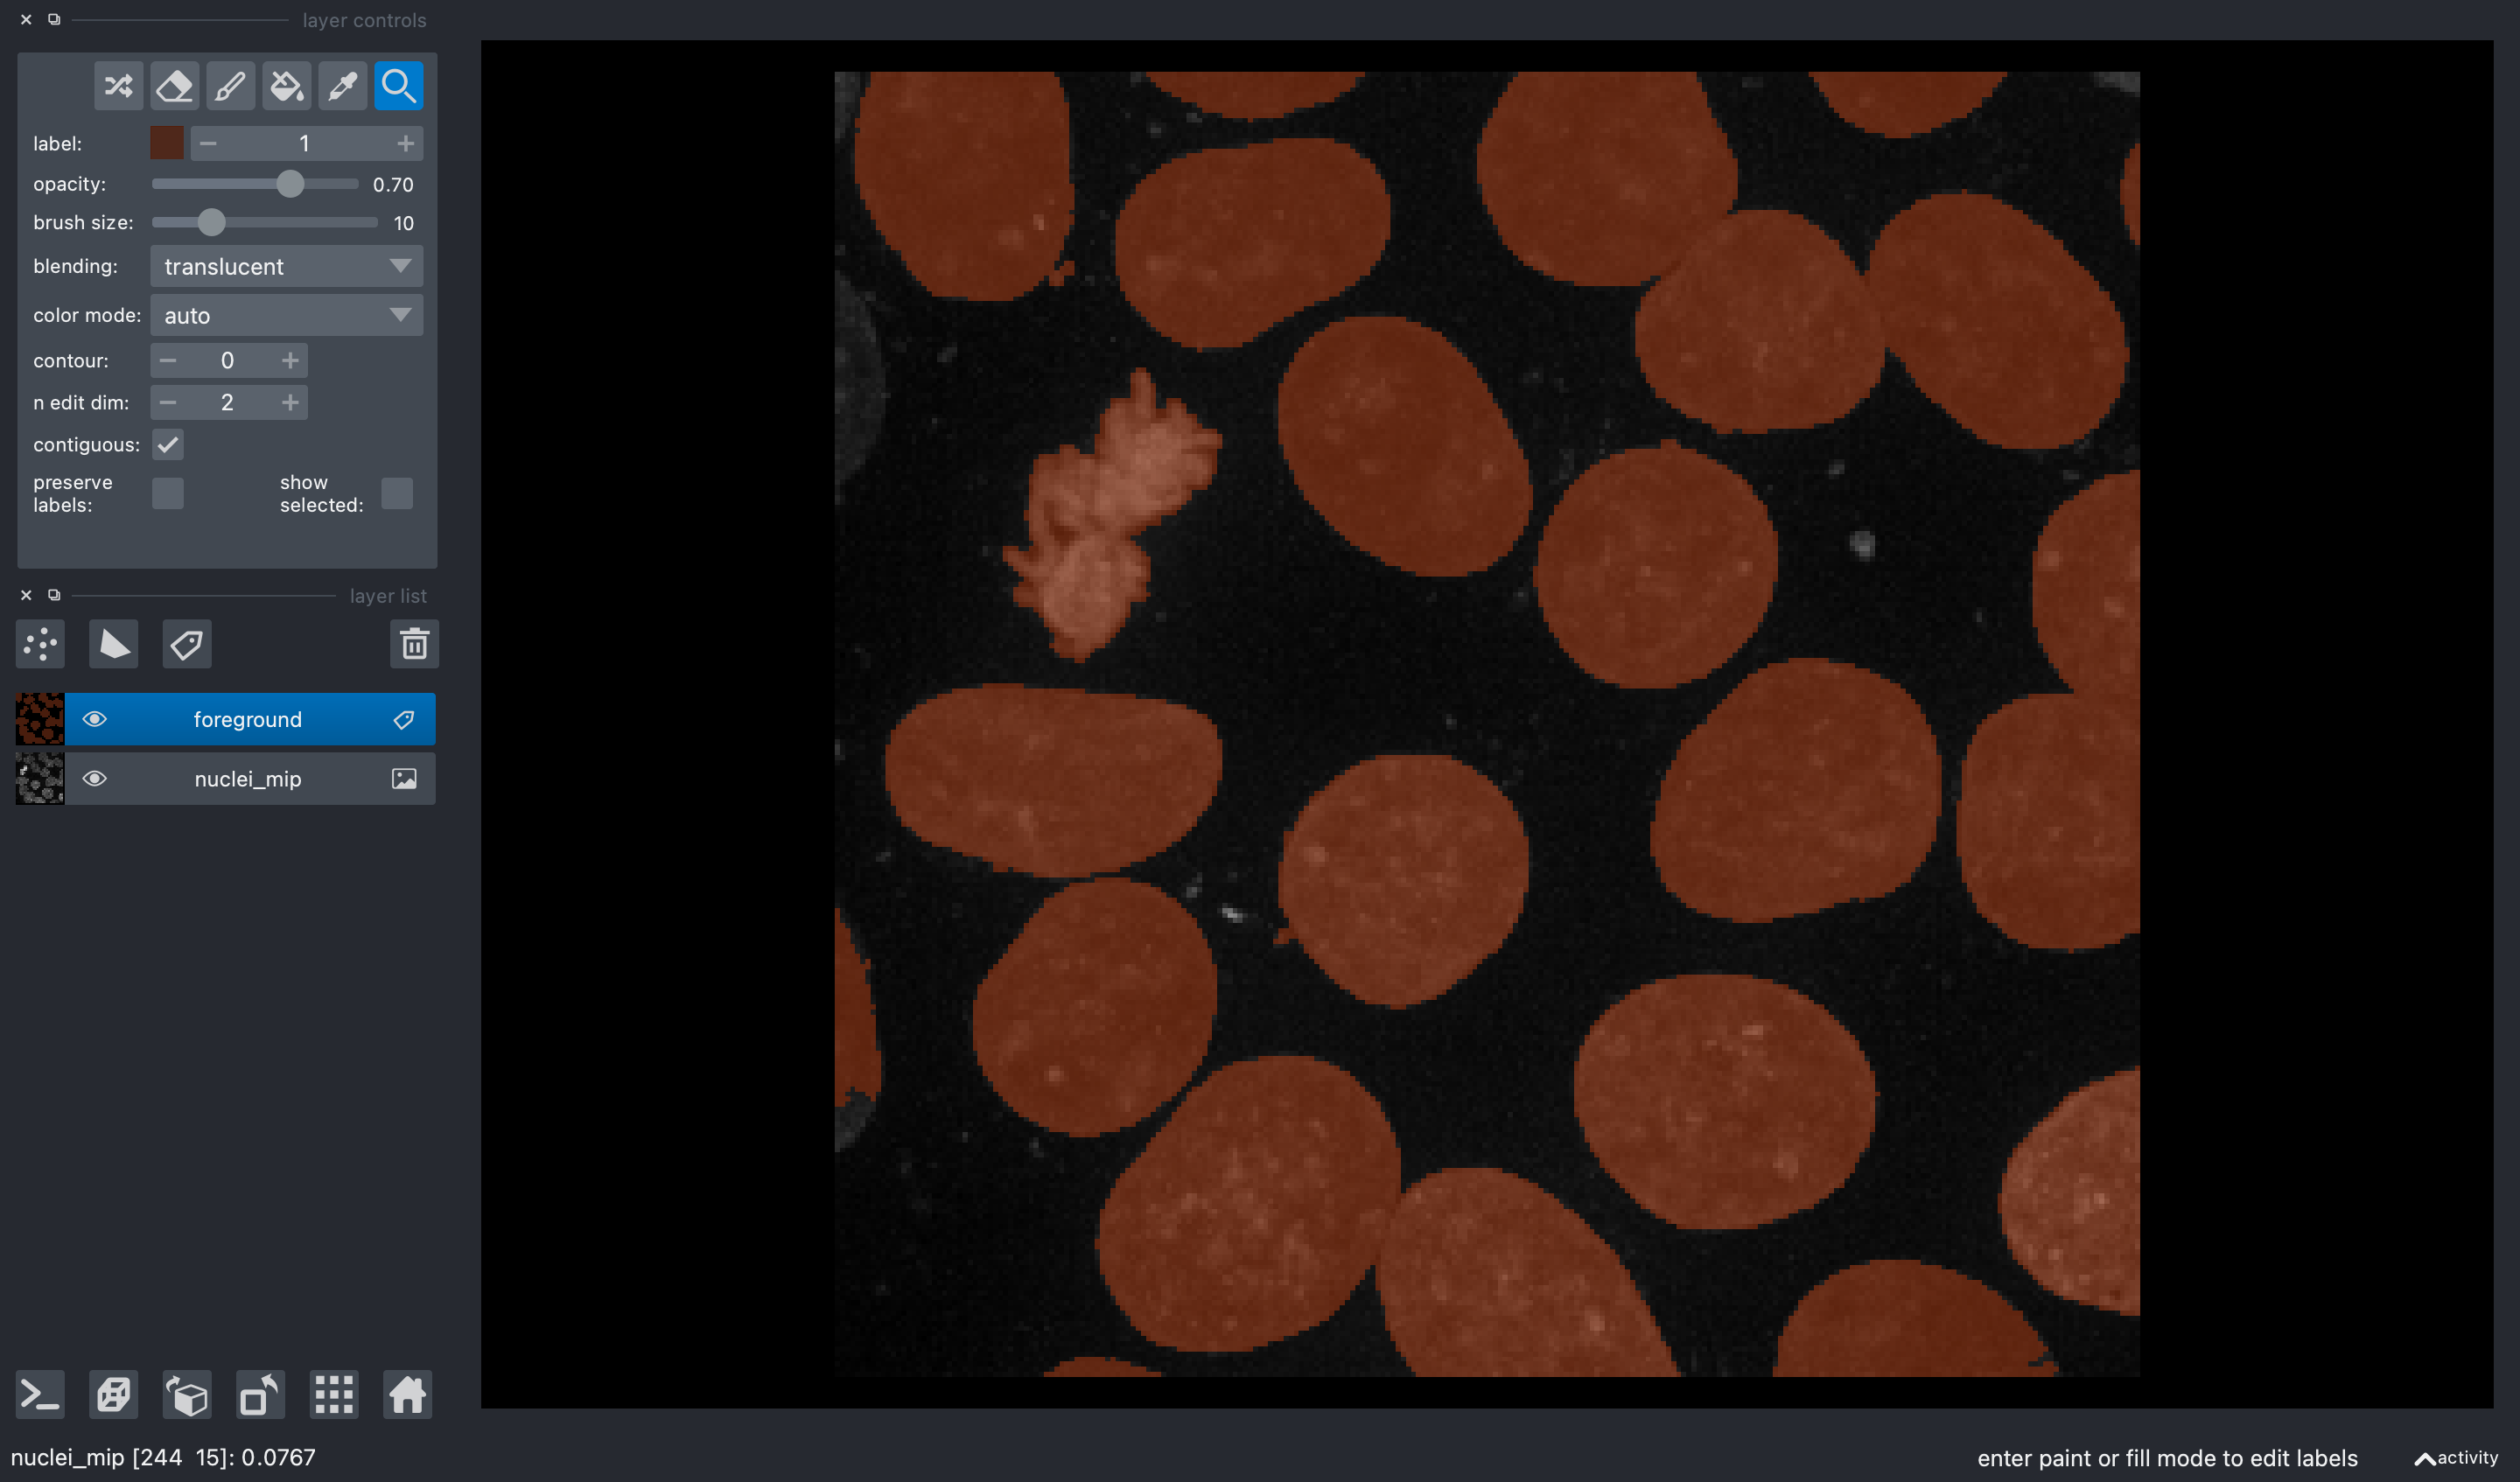

In [13]:
nbscreenshot(viewer)

In [14]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance)

<Image layer 'distance' at 0x7fb72829fb80>

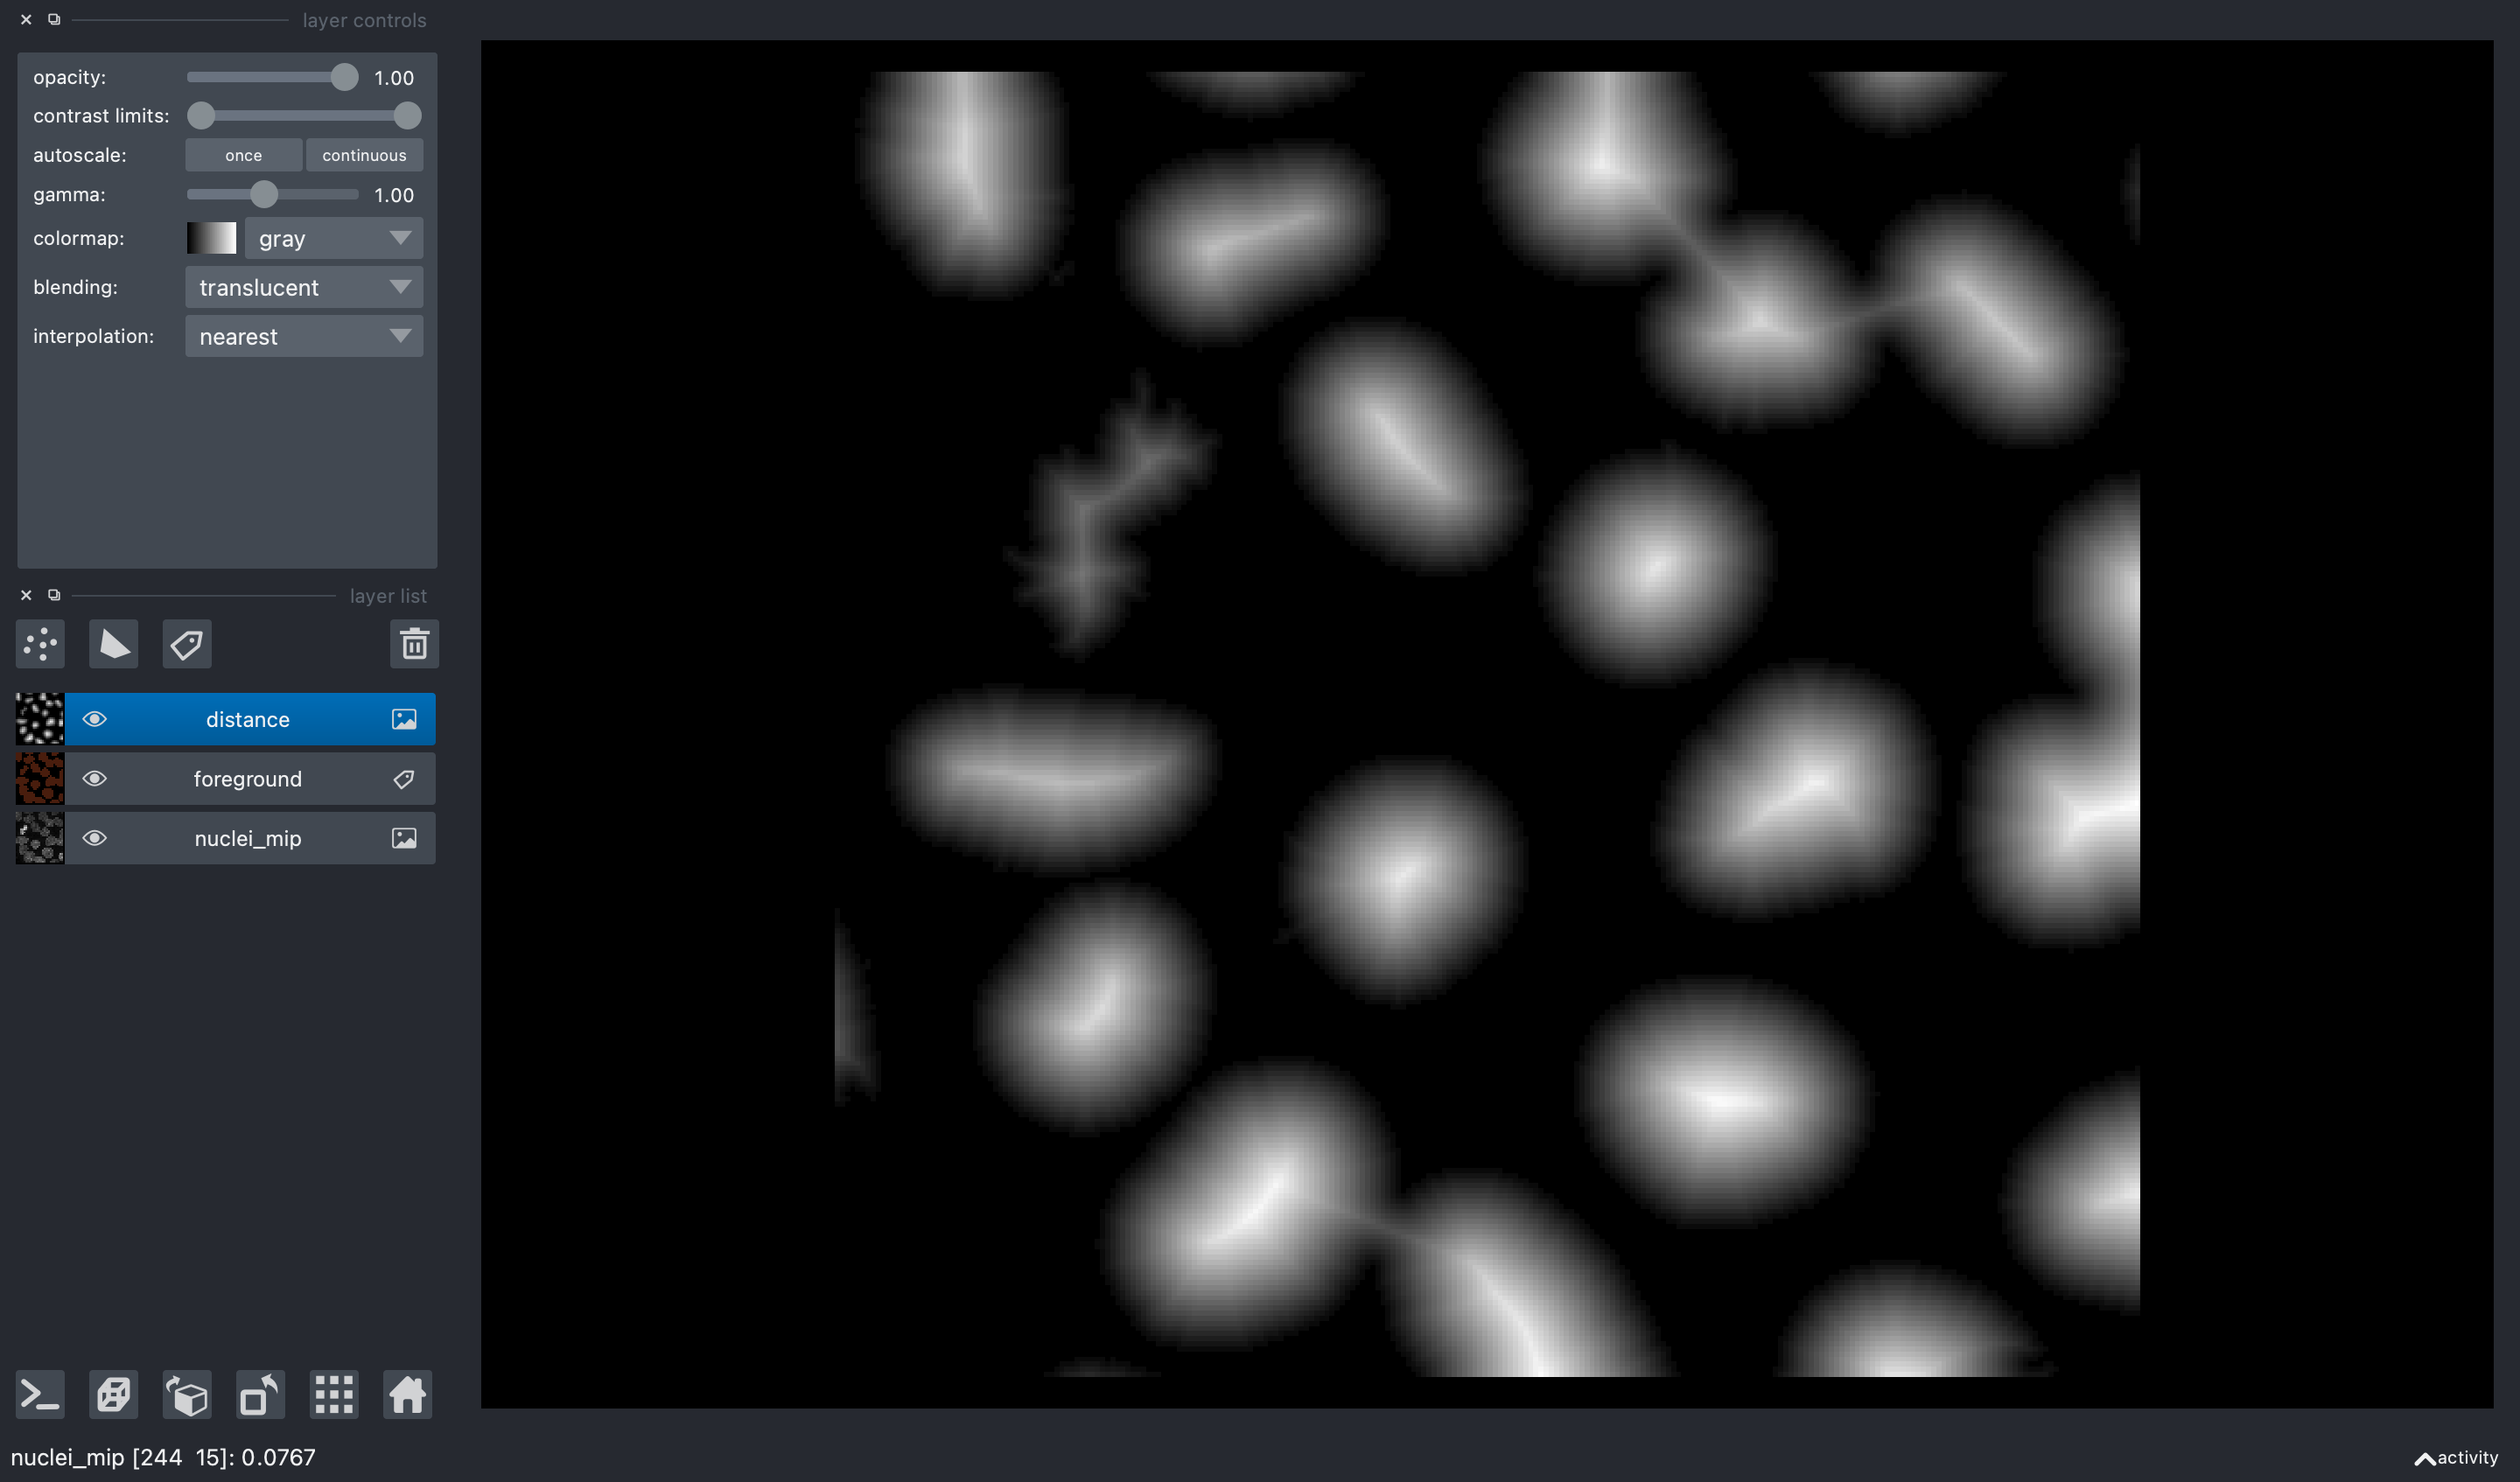

In [15]:
nbscreenshot(viewer)

In [16]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

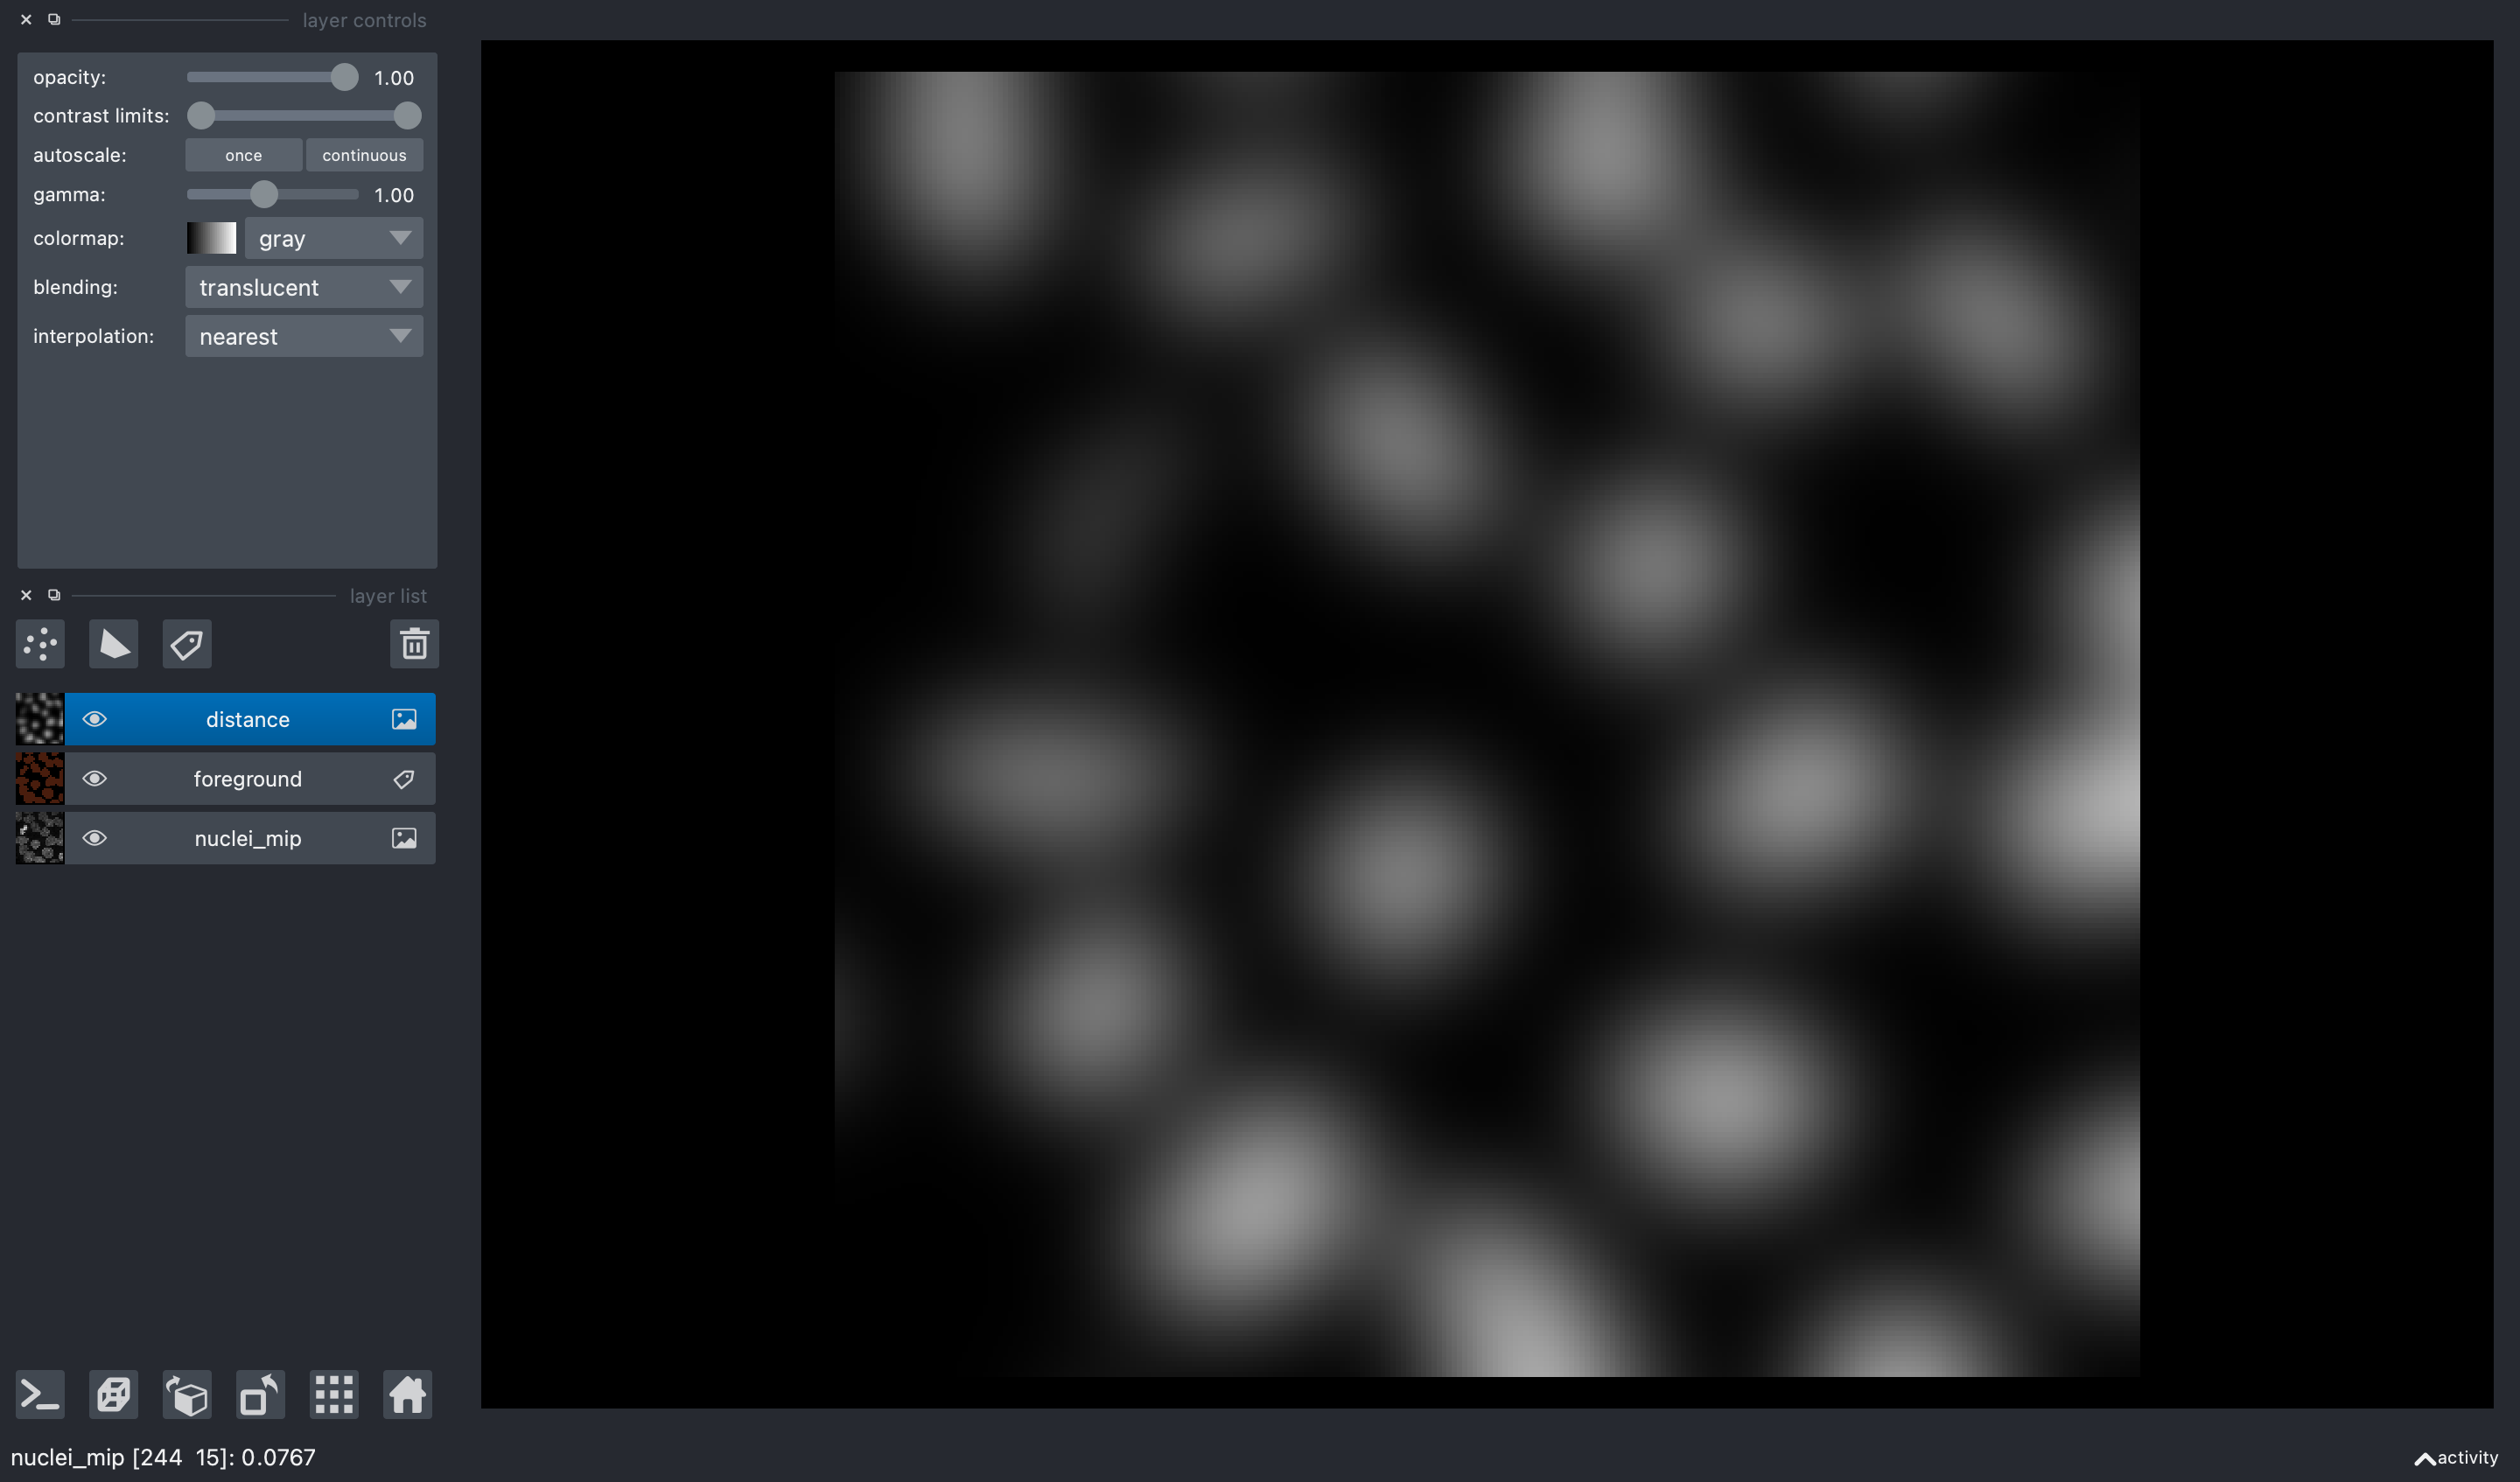

In [17]:
nbscreenshot(viewer)

In [18]:
peak_local_max = feature.peak_local_max(
    smoothed_distance,
    footprint=np.ones((7, 7), dtype=np.bool),
    indices=False,
    labels=measure.label(foreground_processed)
)
peaks = np.nonzero(peak_local_max)

<ipython-input-18-bb62bc05e5fe>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  footprint=np.ones((7, 7), dtype=np.bool),
<ipython-input-18-bb62bc05e5fe>:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_local_max = feature.peak_local_max(


In [19]:
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red');

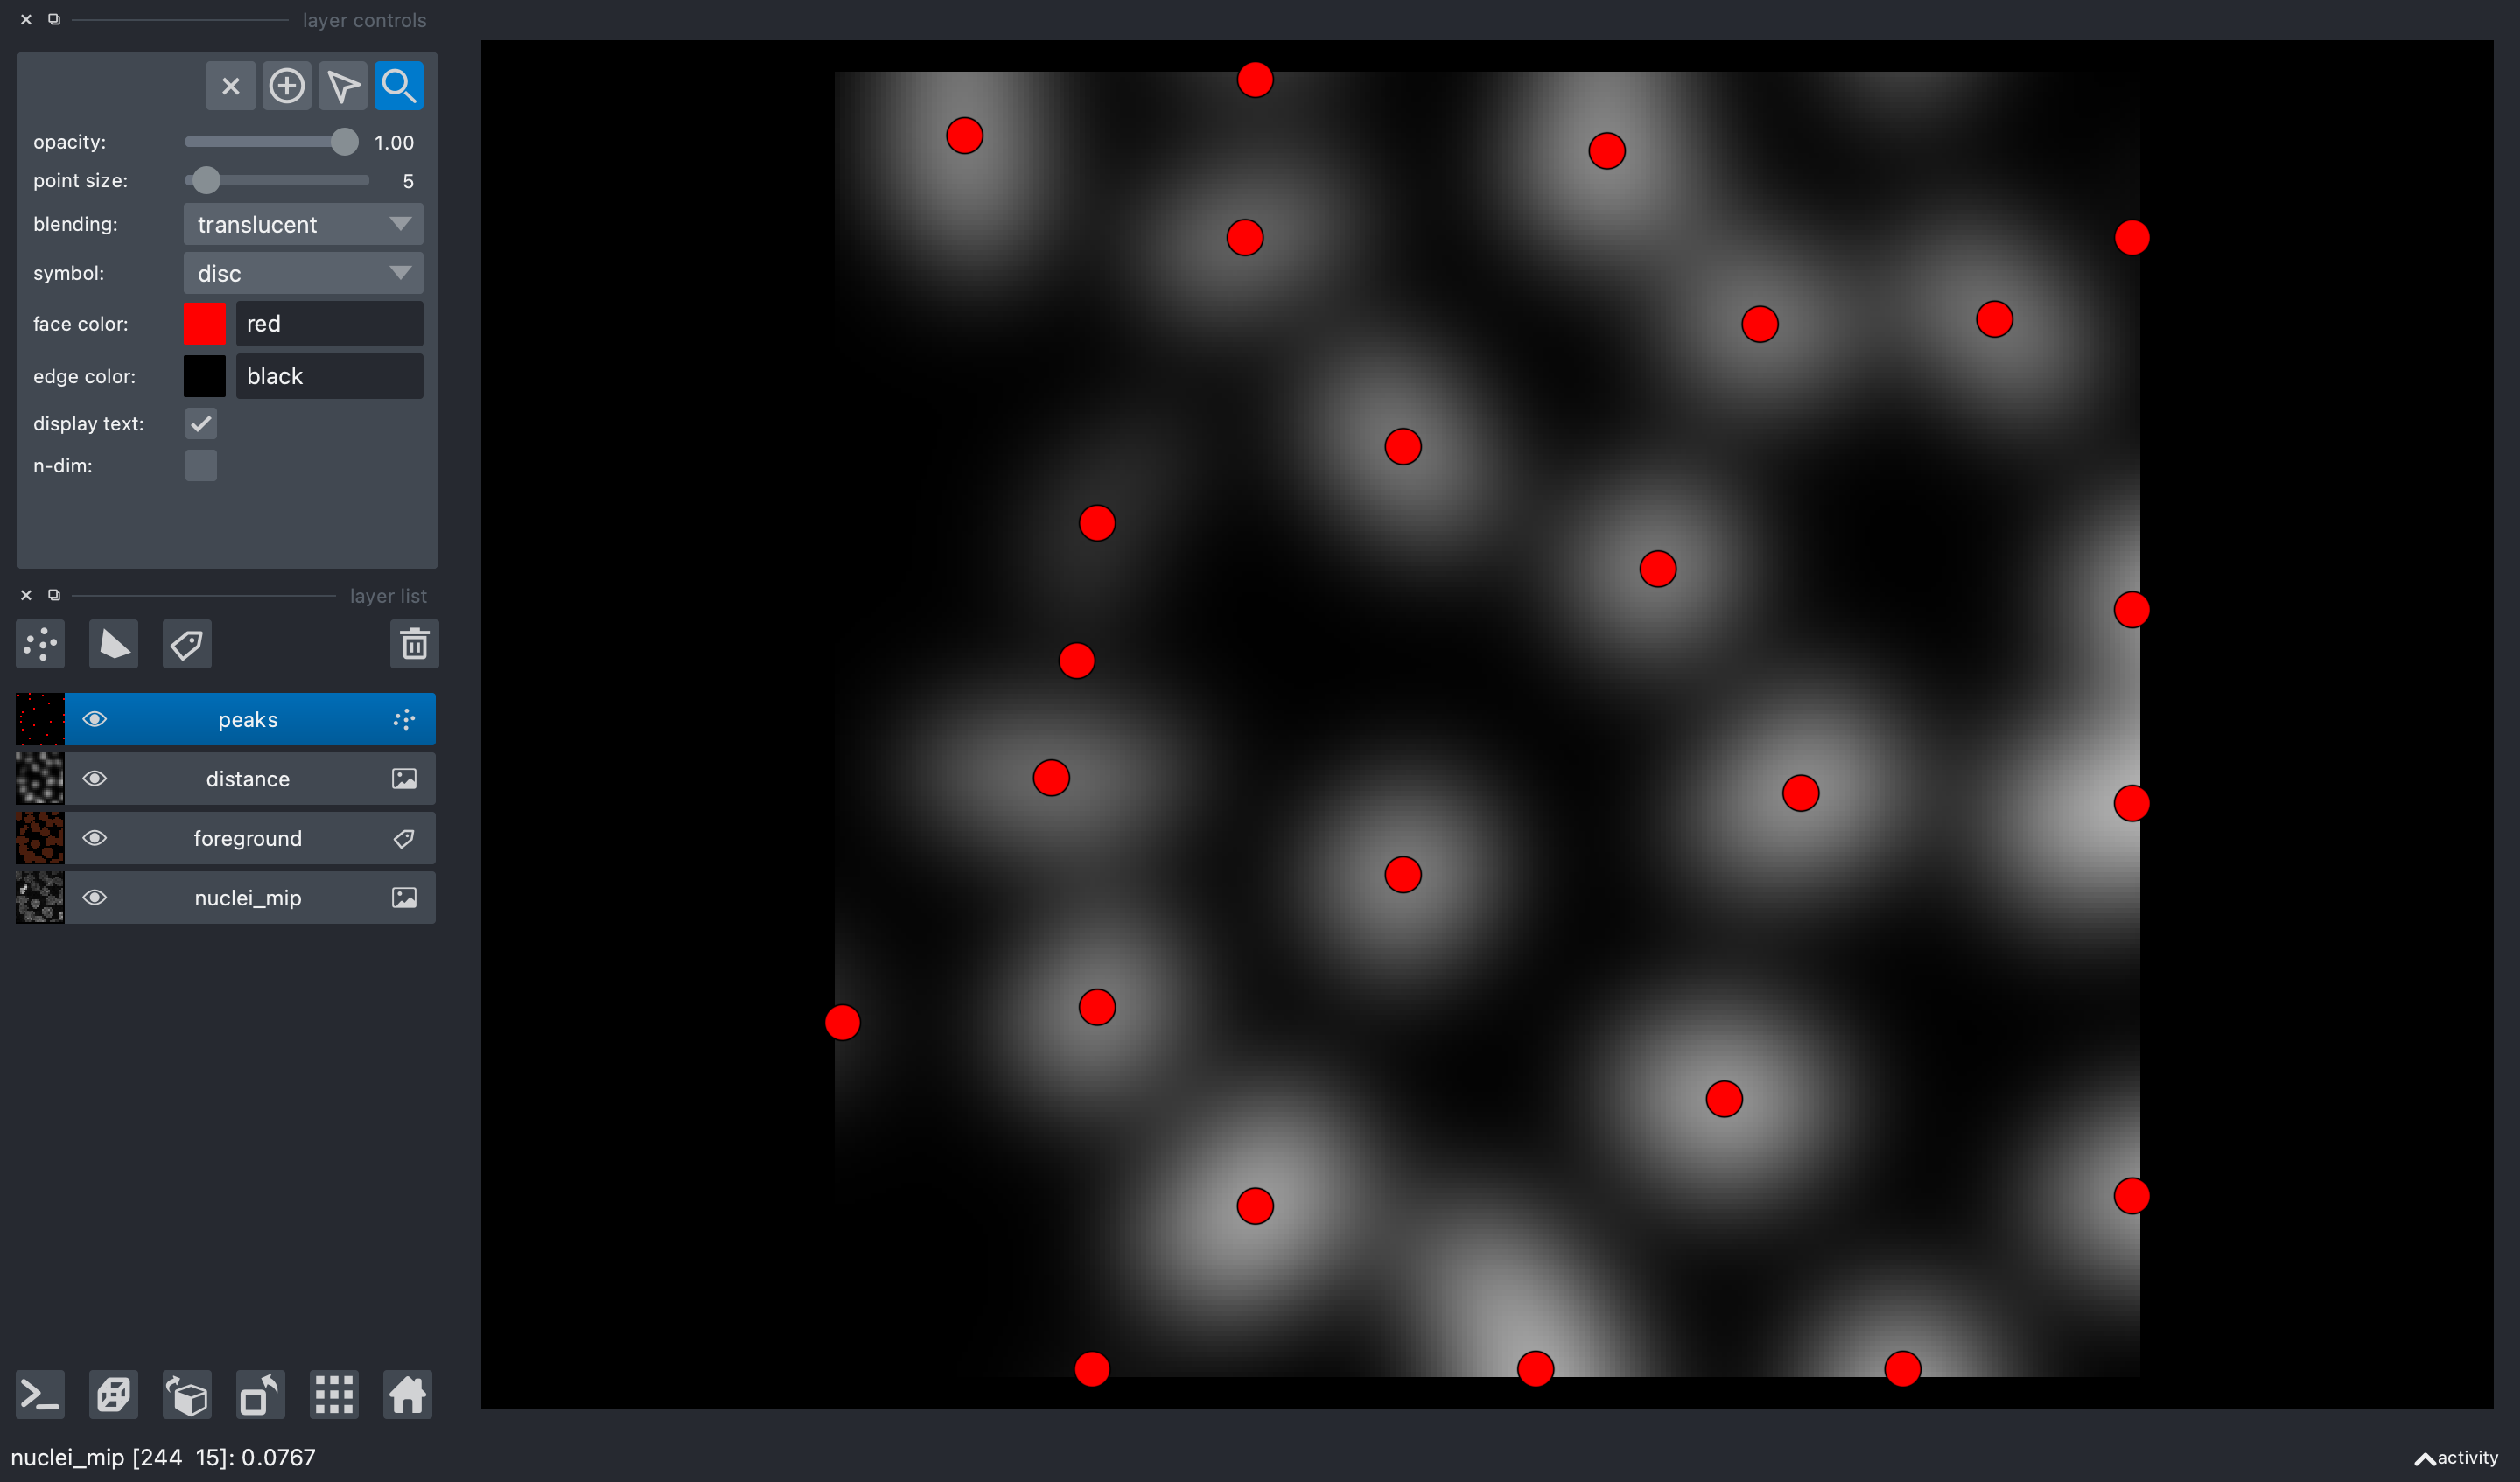

In [20]:
nbscreenshot(viewer)

In [21]:
viewer.layers['peaks'].selected_data = {11}
viewer.layers['peaks'].remove_selected()

In [22]:
new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
seeds = np.zeros(nuclei_mip.shape, dtype=bool)
seeds[(new_peaks[0], new_peaks[1])] = 1

markers = measure.label(seeds)
nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation)

<Labels layer 'nuclei_segmentation' at 0x7fb73cc40640>

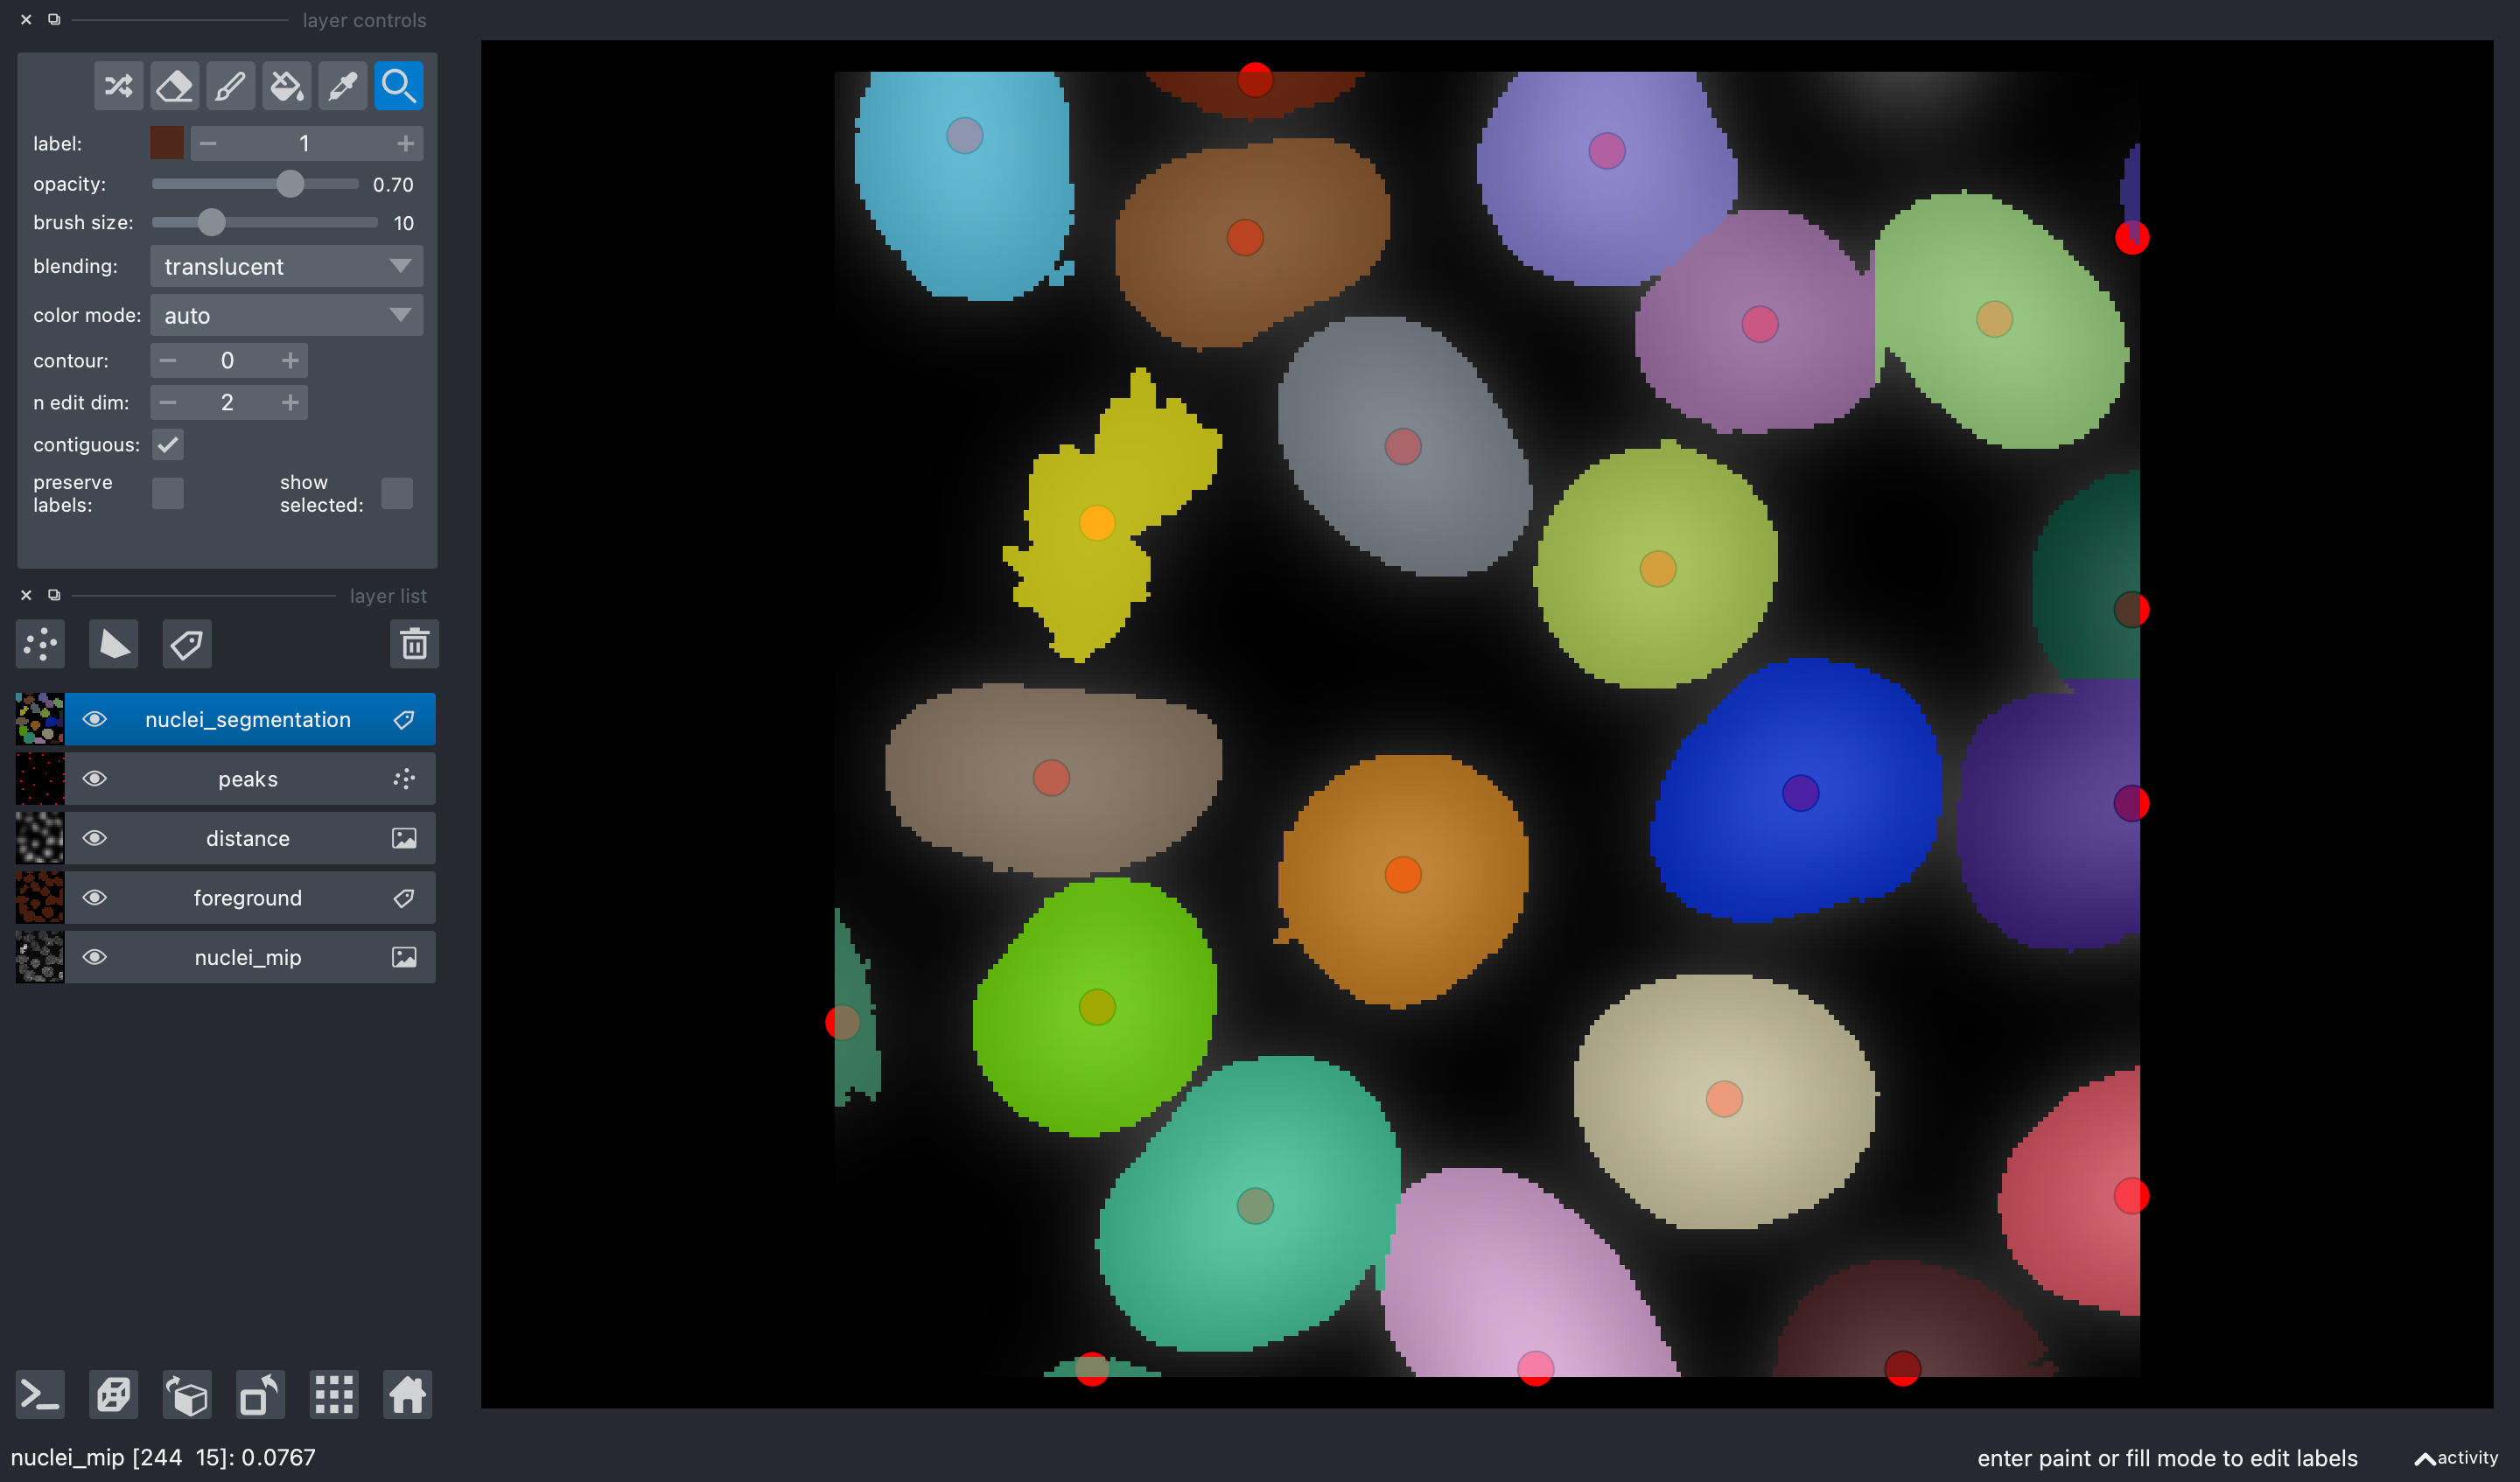

In [23]:
nbscreenshot(viewer)

In [24]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif', plugin='builtins')

['/Users/aburt/Programming/napari-workshop/napari-workshops/notebooks/nuclei-automated-segmentation.tif']

In [25]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [26]:
# Import magicgui and qt functionality
from qtpy.QtWidgets import QSlider
from qtpy.QtCore import Qt
from magicgui import magicgui

In [27]:
from napari.types import ImageData, LabelsData

@magicgui(auto_call=True,
          percentile={"widget_type": "IntSlider", "min": 0, "max": 100})
def threshold(layer: ImageData, percentile: int = 50) -> LabelsData:
    data_min = layer.data.min()
    data_max = layer.data.max()
    return layer.data > data_min + percentile / 100 * (data_max - data_min)

In [28]:
viewer.window.add_dock_widget(threshold, area="left")

AttributeError: 'memoryview' object has no attribute 'min'

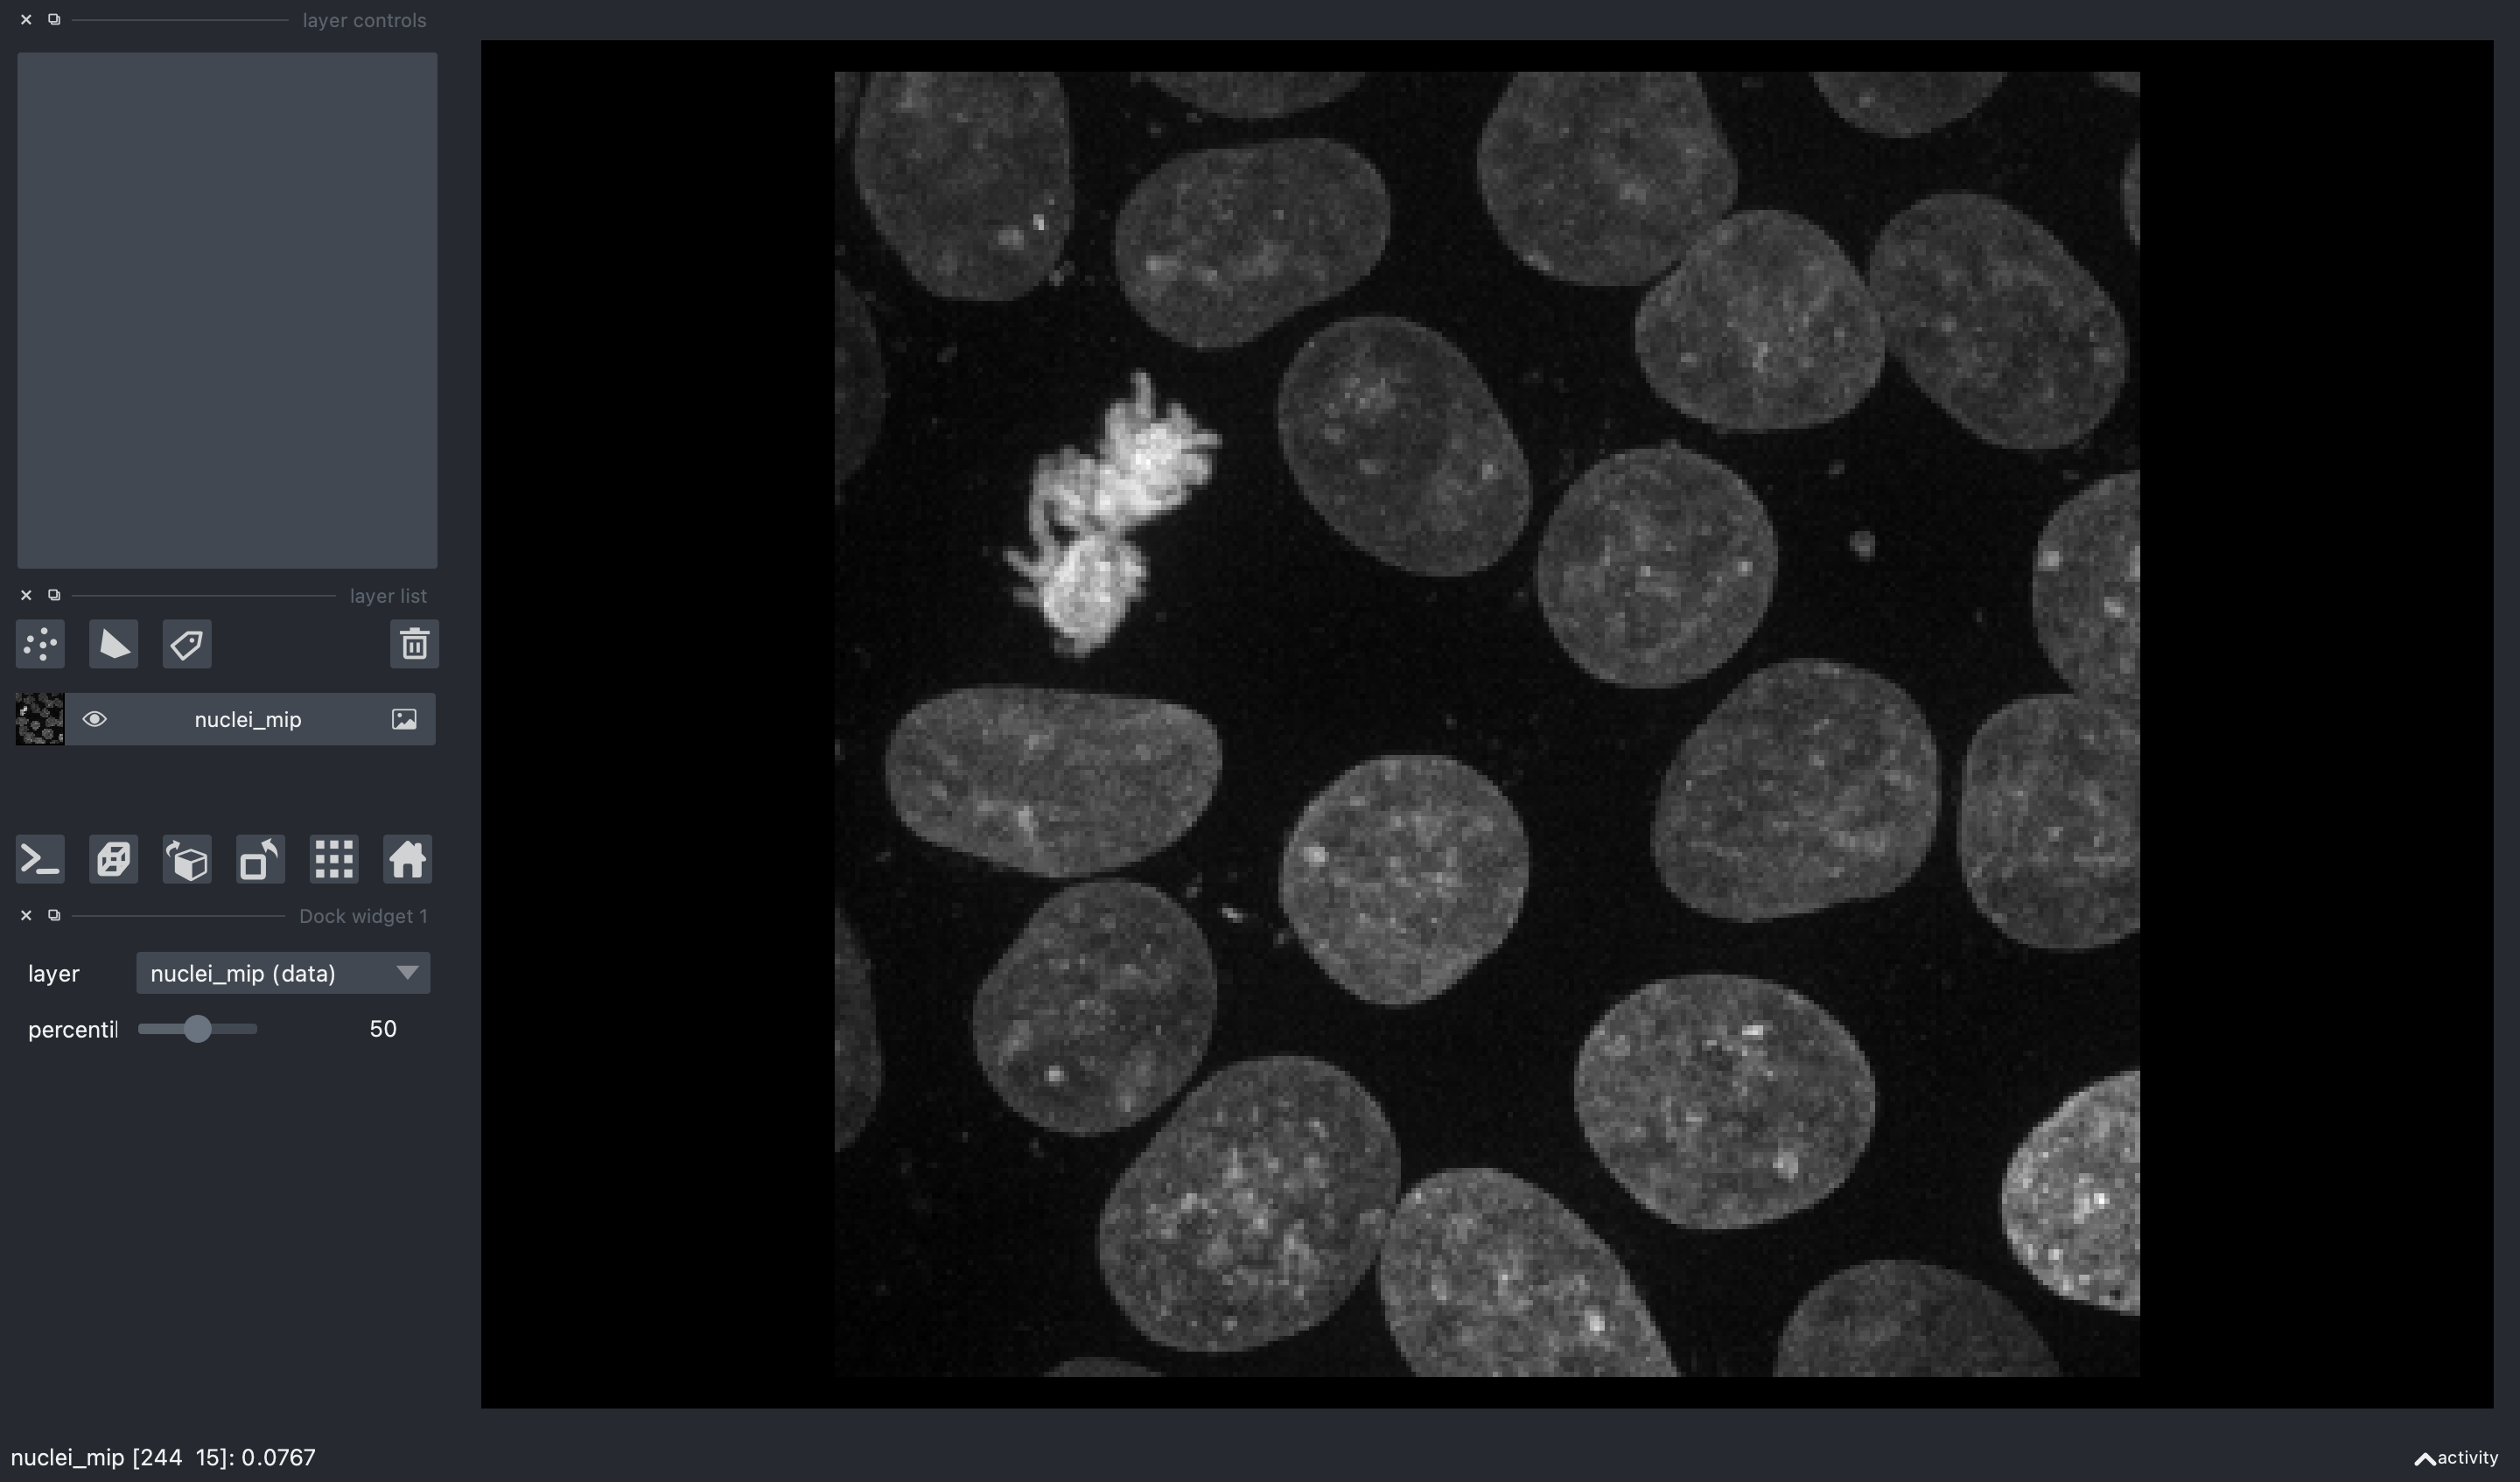

In [29]:
nbscreenshot(viewer)

In [30]:
@viewer.bind_key('Shift-P')
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(data, 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50)
    viewer.layers['threshold result'].data = data_processed

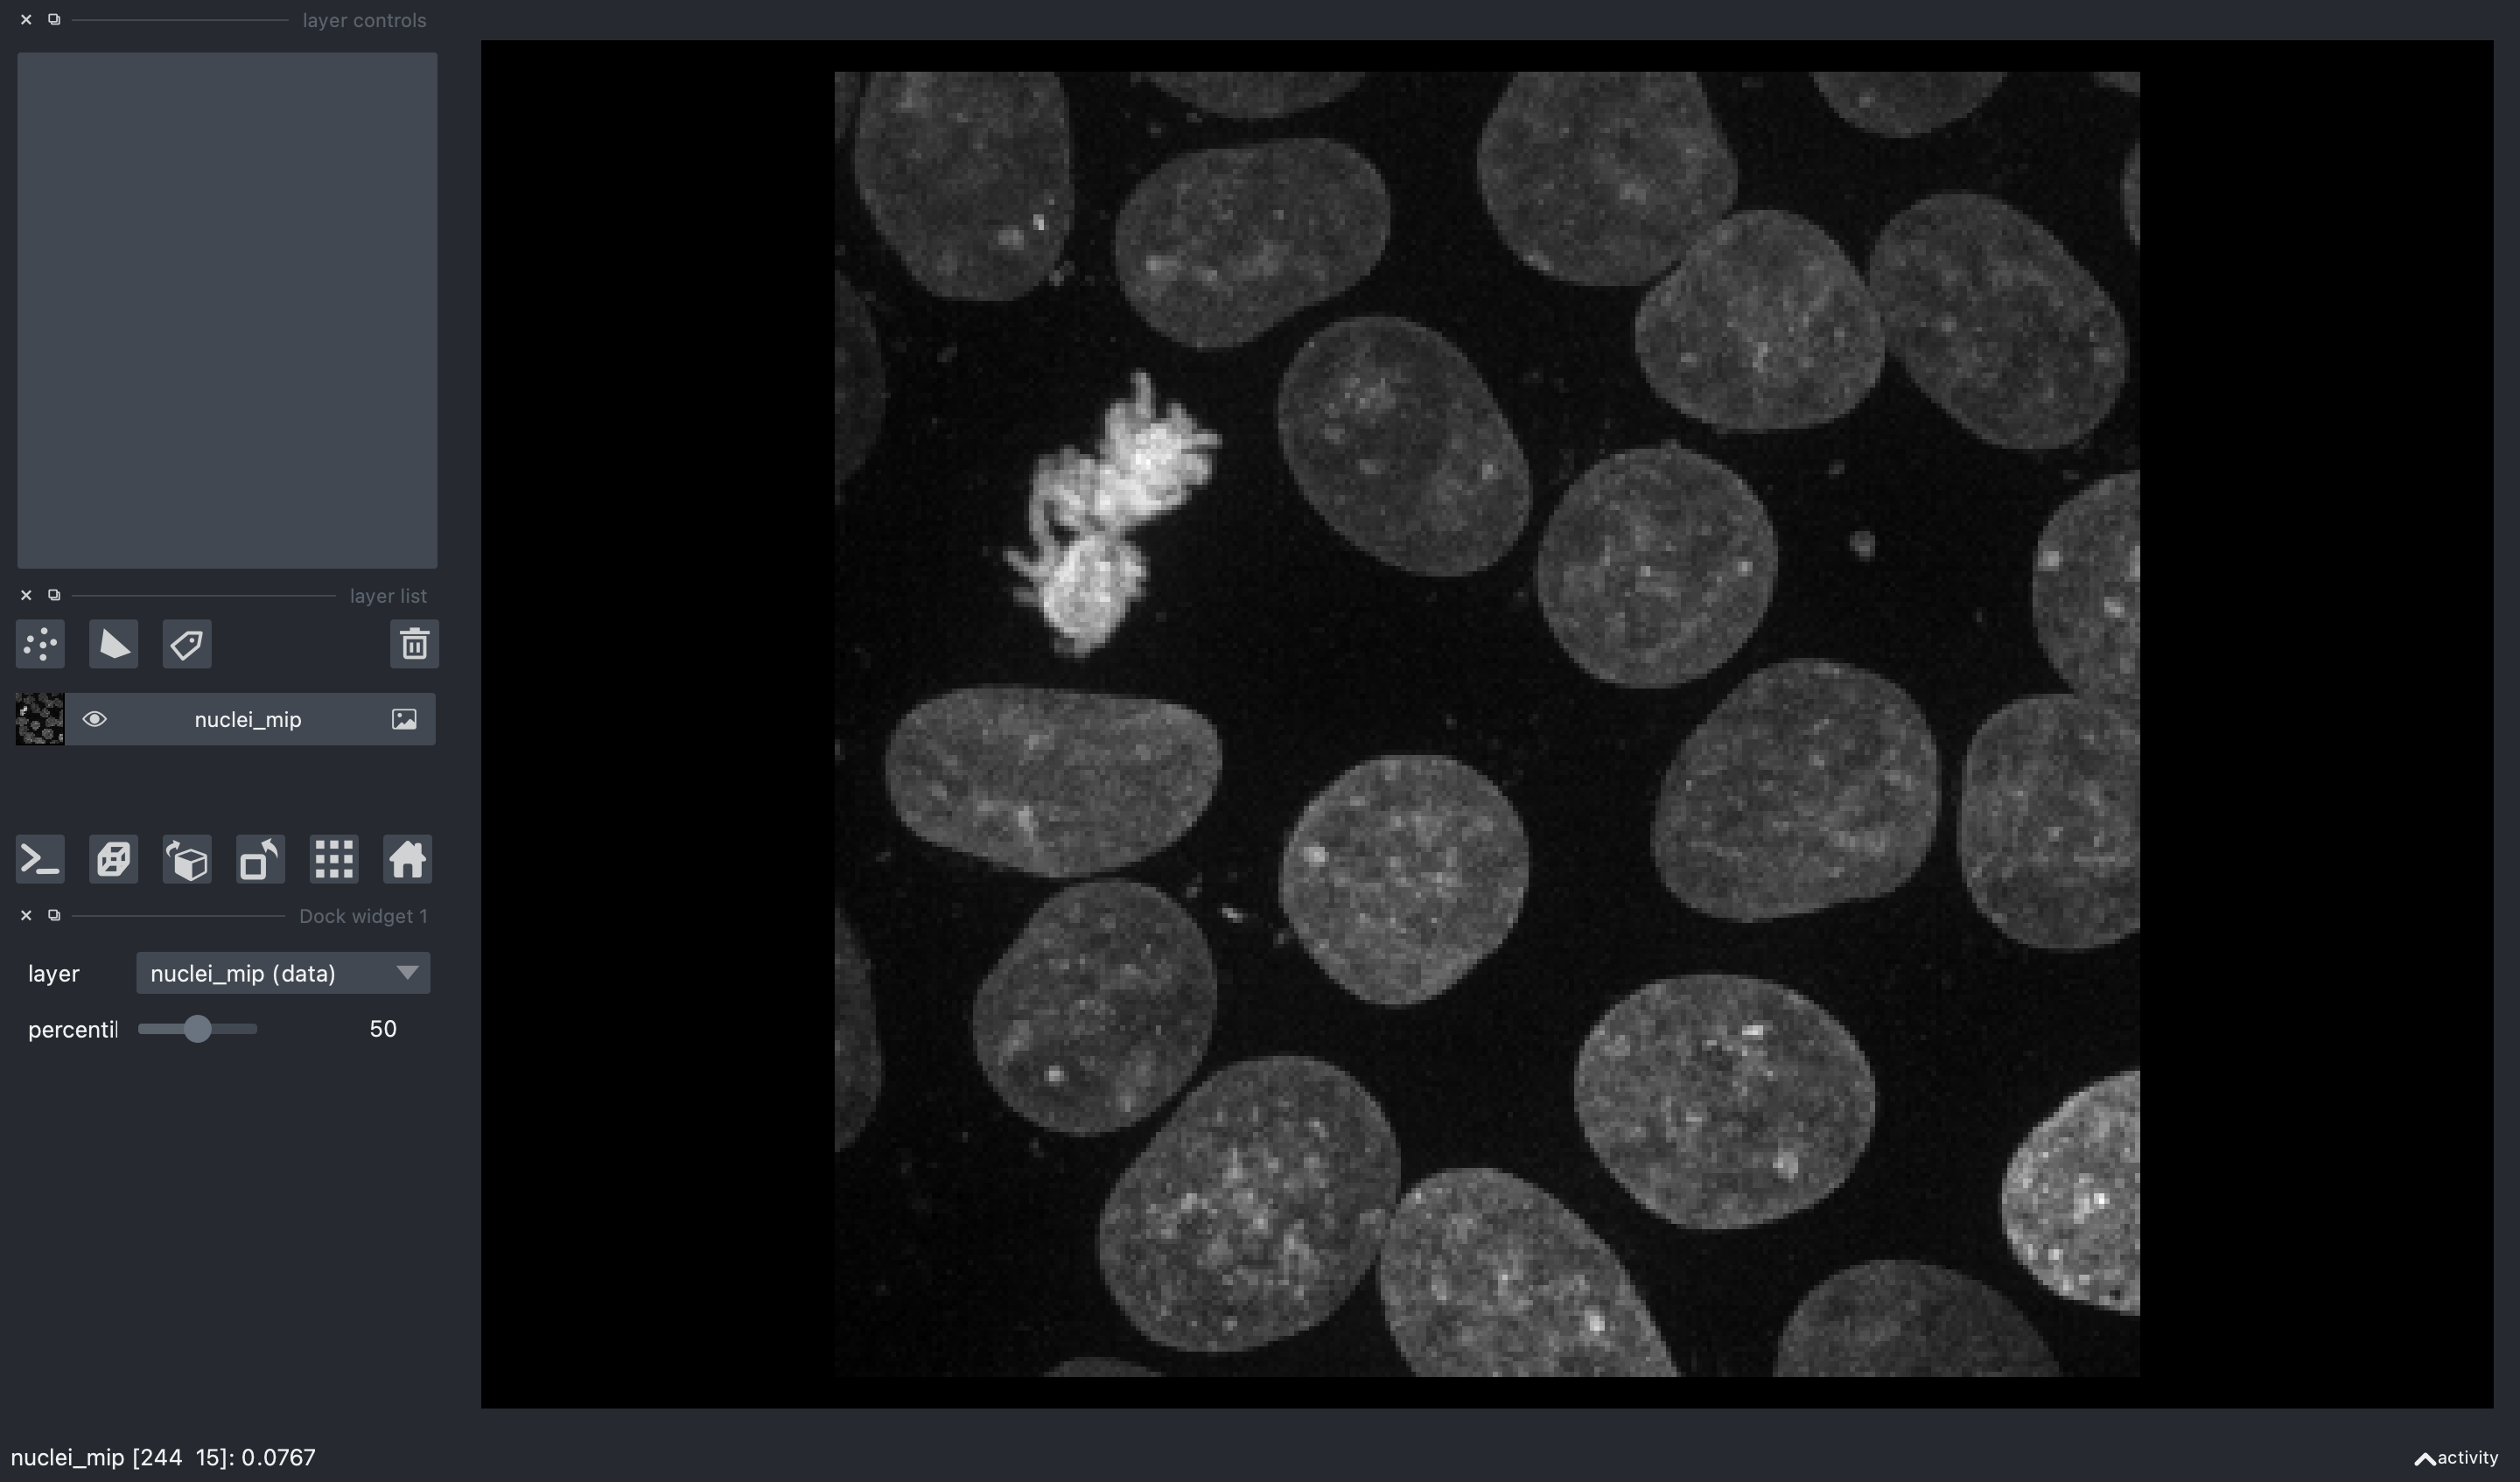

In [31]:
nbscreenshot(viewer)

In [32]:
# Add an empty labels layer with the same shape as our maximum intensity projection
viewer.add_labels(np.zeros(nuclei_mip.shape, dtype=int), name='nuclei segmentation')

<Labels layer 'nuclei segmentation' at 0x7fb73d1b9c40>

In [33]:
# Bind another keybinding to complete segmentation
@viewer.bind_key('Shift-S')
def complete_segmentation(viewer):
    foreground = viewer.layers['threshold result'].data
    distance = ndimage.distance_transform_edt(foreground)
    smoothed_distance = filters.gaussian(distance, 10)
    peak_local_max = feature.peak_local_max(
        smoothed_distance,
        footprint=np.ones((7, 7), dtype=np.bool),
        indices=False,
        labels=measure.label(foreground)
    )
    peaks = np.nonzero(peak_local_max)
    seeds = np.zeros(smoothed_distance.shape, dtype=bool)
    seeds[(peaks[0], peaks[1])] = 1

    markers = measure.label(seeds)
    nuclei_segmentation = segmentation.watershed(
        -smoothed_distance, 
        markers, 
        mask=foreground
    )
    viewer.layers['nuclei segmentation'].data = nuclei_segmentation

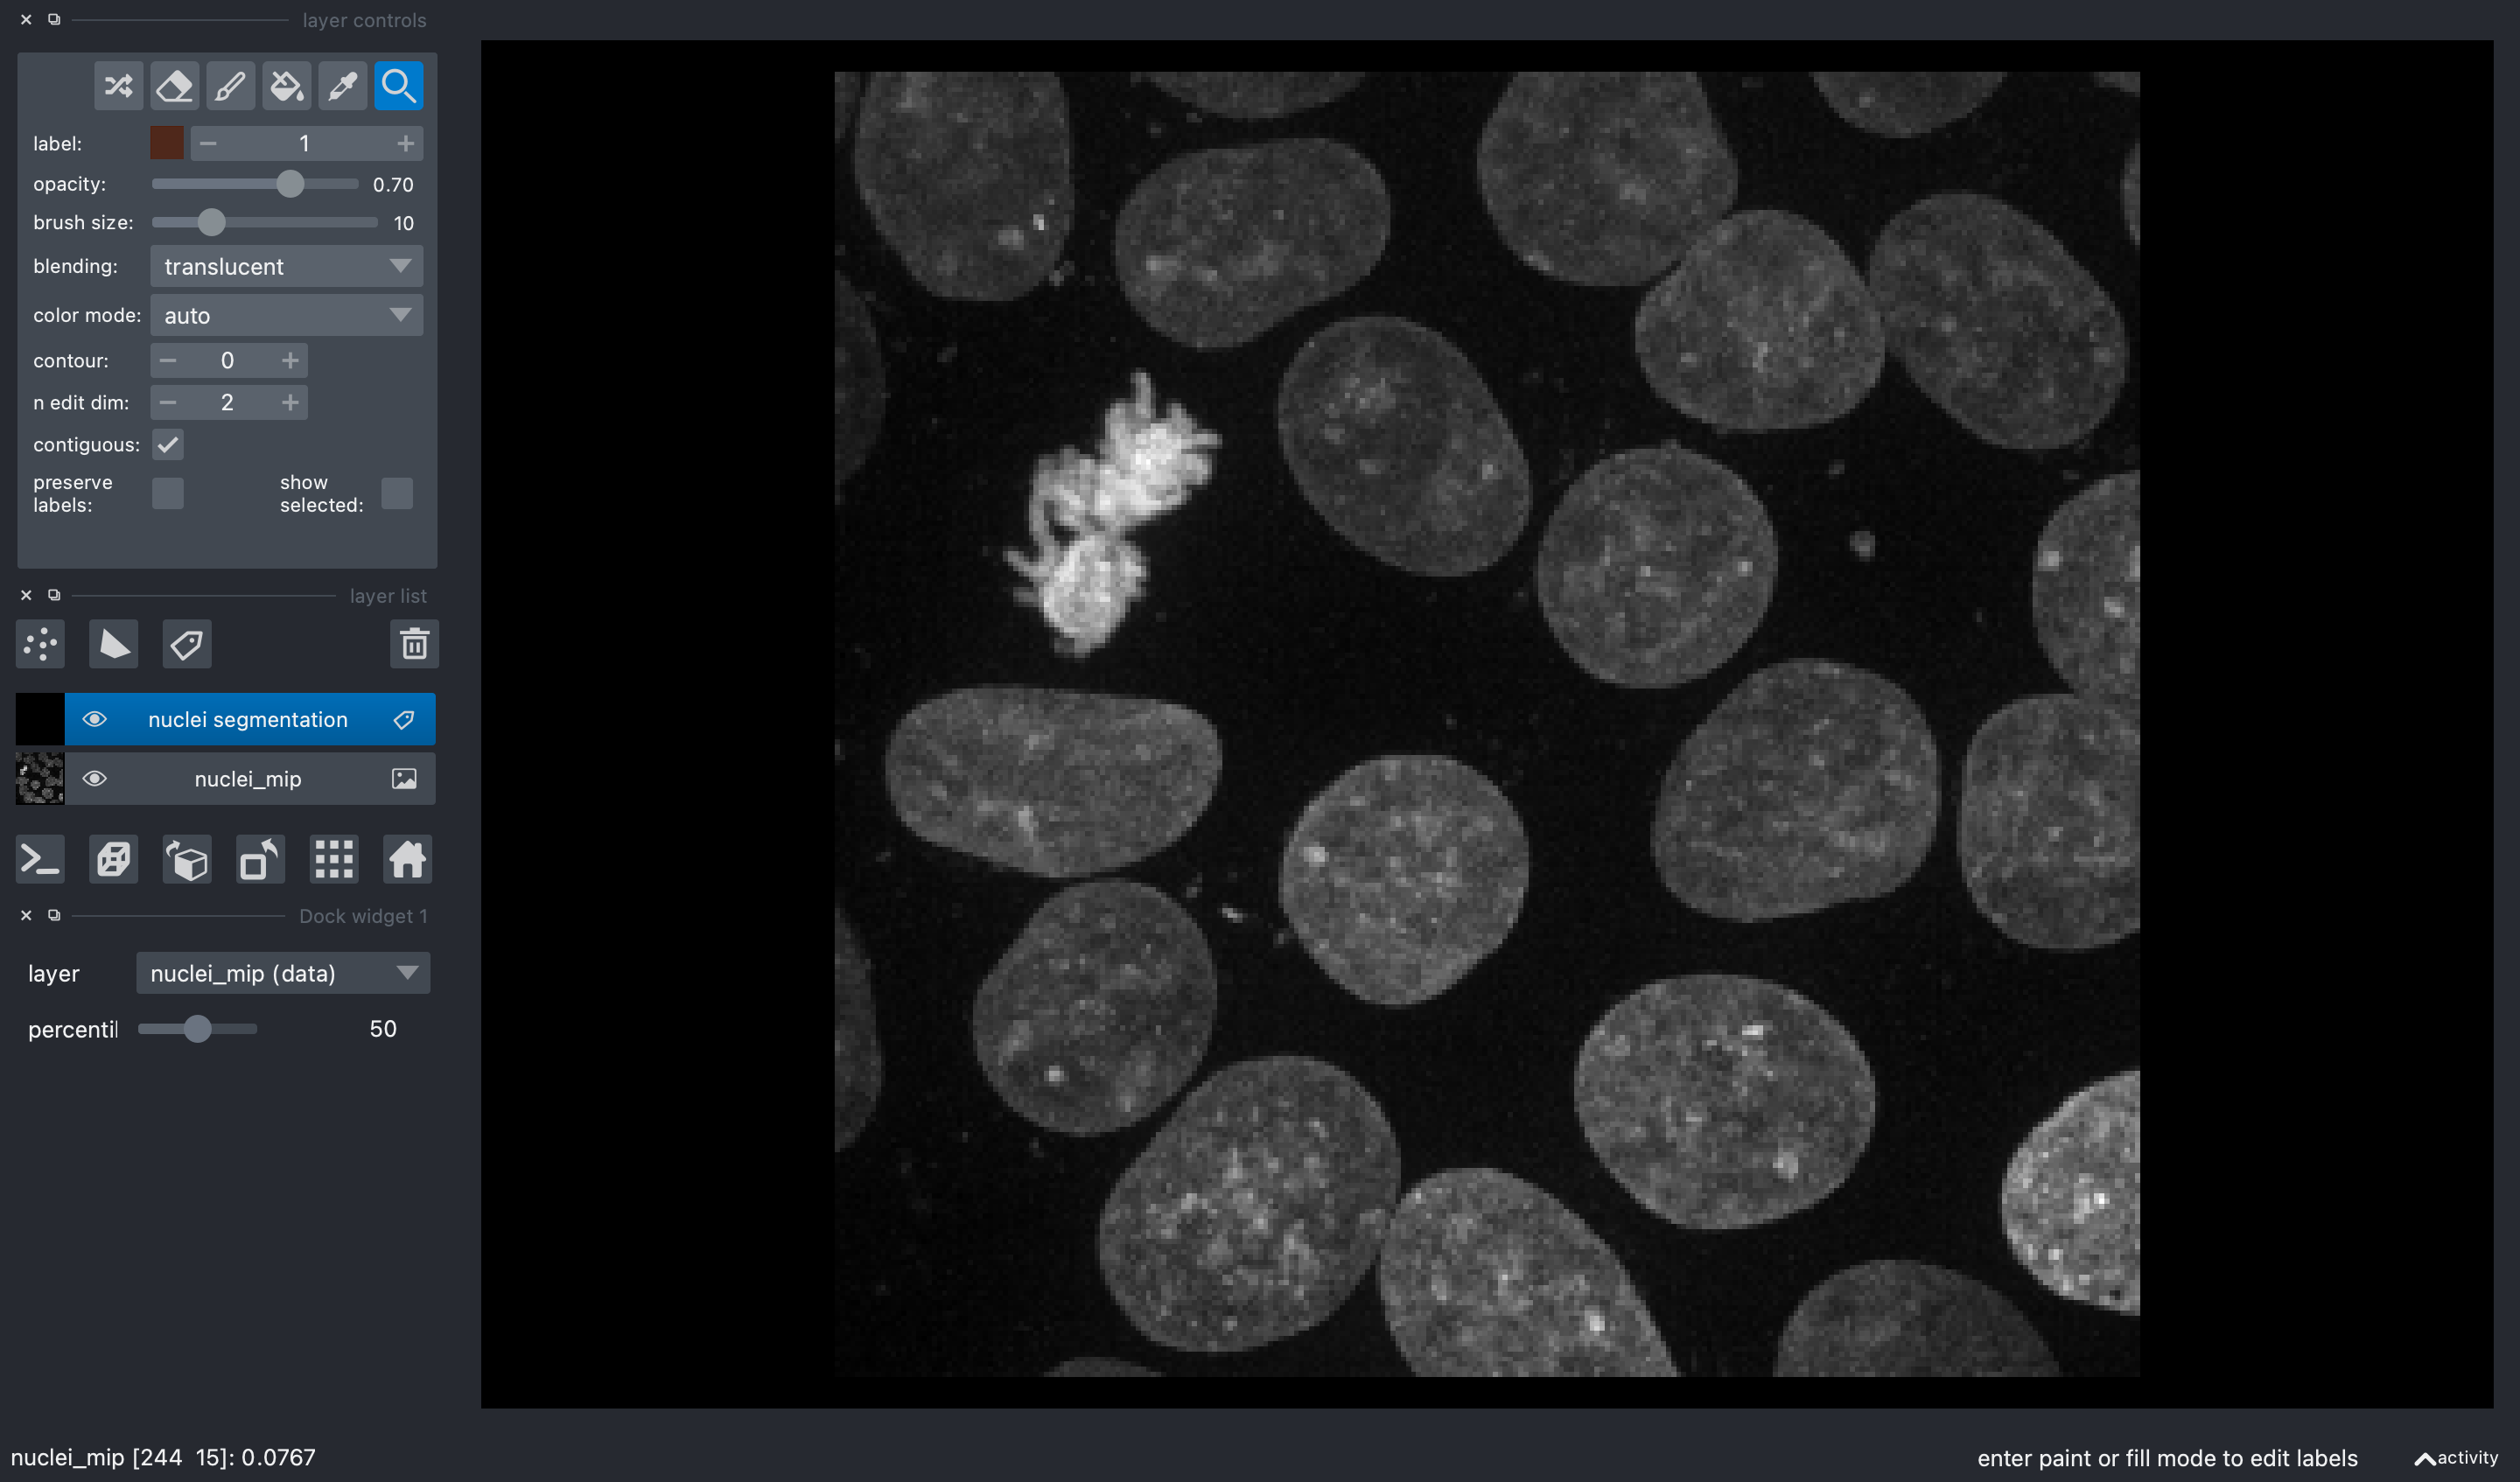

In [34]:
nbscreenshot(viewer)